# Генерация SMILES с заданными свойствами #

В этом эксперименте мы будем оптимизировать параметры предобученной RNN для генерации молекул с заданной энтальпией.

Основанно на:
**Deep reinforcement learning for de novo drug design. Science advances, 4(7), eaap7885.** 

## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

In [4]:
sys.path.append('./release/')

In [5]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

In [6]:
no_cuda=False

In [7]:
use_cuda = not no_cuda and torch.cuda.is_available()

In [8]:
torch.cuda.is_available()

False

In [9]:
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData
from utils import canonical_smiles

RDKit WARNING: [10:43:39] Enabling RDKit 2019.09.1 jupyter extensions


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## Setting up the generator

### Loading data for the generator

In [11]:
gen_data_path = './data/chembl_22_clean_1576904_sorted_std_final.smi'

In [12]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

In [13]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

## Util functions

**plot_hist** function plots histogram of predicted properties and a vertical line for thershold.

In [14]:
def plot_hist(prediction, n_to_generate):
    print("Mean value of predictions:", prediction.mean())
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    ax.set(xlabel='Predicted pIC50', 
           title='Distribution of predicted pIC50 for generated molecules')
    plt.show()

**estimate_and_update** function:

1) generates n_to_generate number of SMILES strings

2) filters invalid SMILES

3) predicts enthalpy for valid SMILES

4) plots histogram of predicted enthalpy

5) Returns valid SMILES and their predicted enthalpy

In [15]:
def estimate_and_update(generator, predictor, n_to_generate, **kwargs):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, get_features=get_fp)  
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

## Initializing and training the generator

We will used stack augmented generative GRU as a generator. The model was trained to predict the next symbol from SMILES alphabet using the already generated prefix. Model was trained to minimize the cross-entropy loss between predicted symbol and ground truth symbol. Scheme of the generator when inferring new SMILES is shown below:

<img src="./figures/generator.png">

Initialize stack-augmented generative RNN:

In [16]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

If you want train the model from scratch, uncomment the lines below:

In [17]:
model_path = './checkpoints/generator/checkpoint_biggest_rnn'

In [17]:
losses = my_generator.fit(gen_data, 15000)

Training in progress...:   0%|                                                               | 0/15000 [00:00<?, ?it/s]./release\data.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)
Training in progress...:   1%|▎                                                  | 99/15000 [06:31<13:57:19,  3.37s/it]

 35s (100 0%) 2.6777]
<71(r]H6)]rr
s1s@]58I/B> 



Training in progress...:   1%|▋                                                 | 199/15000 [13:05<12:15:36,  2.98s/it]

 10s (200 1%) 2.1210]
<18o3-ep)N#(OS-A@#=Ic(
450ScH<5#n972+o1N2s/cI2<c(SCC)7Hc1Cc\c1sn(1cC()C(C(CCC4C1CCA((=Occ3c()C(C)[21) 



Training in progress...:   2%|▉                                                 | 299/15000 [19:44<15:57:39,  3.91s/it]

 47s (300 2%) 2.0752]
<
%HI)+nHO2(C(ncCC3CCcc<c11c1c2ccn(1(OccccnSH> 



Training in progress...:   3%|█▎                                                | 399/15000 [25:51<13:53:10,  3.42s/it]

 58s (400 2%) 1.7097]
<> 



Training in progress...:   3%|█▋                                                | 499/15000 [32:15<16:21:50,  4.06s/it]

 18s (500 3%) 1.9291]
<s/N1> 



Training in progress...:   4%|█▉                                                | 599/15000 [38:41<15:57:31,  3.99s/it]

 45s (600 4%) 2.0311]
<eSS76)=/CNS-c(=)C(OC)(c1Cc2cc1cccccccnc(-)N=))2(CC)1> 



Training in progress...:   5%|██▎                                               | 699/15000 [44:54<14:23:51,  3.62s/it]

 59s (700 4%) 1.8531]
<A+eC> 



Training in progress...:   5%|██▋                                               | 799/15000 [50:59<13:52:35,  3.52s/it]

 2s (800 5%) 1.9941]
<@)e(O2))cccccccc3ccccc2ccc(6N1)ccc2)CCs5s=Oc(rC1)c1C1ccccc(C)CC(N)N/C1)cccc> 



Training in progress...:   6%|██▉                                               | 899/15000 [57:20<14:01:55,  3.58s/it]

 24s (900 6%) 1.6024]
<3Ccc]> 



Training in progress...:   7%|███▏                                            | 999/15000 [1:03:27<17:18:21,  4.45s/it]

 33s (1000 6%) 1.3189]
<C2CCNc1\c1\H)csc1ccsccc2c2)s=()=O)C(=OC(=O)C(#O)2cc(c1)c2c(C)c1n)c1c(OCCC1)N==NC2(c2cc1.=O3Nc2Ccc(c1 



Training in progress...:   7%|███▍                                           | 1099/15000 [1:09:31<14:44:51,  3.82s/it]

 35s (1100 7%) 1.8034]
<COcc1c1cccc3cccc1cn)1)ccn(c1)(=O)C)N4CN(=OCCccccc> 



Training in progress...:   8%|███▊                                           | 1199/15000 [1:15:49<14:36:37,  3.81s/it]

 52s (1200 8%) 1.2183]
<A1NC(=O)=O)ccc1> 



Training in progress...:   9%|████                                           | 1299/15000 [1:22:07<16:06:56,  4.23s/it]

 11s (1300 8%) 1.4813]
<1CSCC2(C)CNC(O)=N](C1CCNC=O(=O)c1ccc1)C2CNCCC1CCC(=O=O)CCS2[C(C2C2> 



Training in progress...:   9%|████▍                                          | 1399/15000 [1:28:56<14:41:39,  3.89s/it]

 1s (1400 9%) 1.6930]
<C(CCCNCC1ccc(nO)(=O)C)=O)3C(=O)C1> 



Training in progress...:  10%|████▋                                          | 1499/15000 [1:35:10<13:57:25,  3.72s/it]

 11s (1500 10%) 1.3065]
<rCC> 



Training in progress...:  11%|█████                                          | 1599/15000 [1:41:20<13:52:36,  3.73s/it]

 23s (1600 10%) 2.3611]
<CCON2N(=O)=CN)COCCN1CC(=O)ccccnc2))(=O))(> 



Training in progress...:  11%|█████▎                                         | 1699/15000 [1:47:40<13:13:18,  3.58s/it]

 44s (1700 11%) 1.5526]
<Cn1c2ccc3Fc(C1CC2C9(=O)ccccc3c(N)C=2)CC(=N)C-F)c1ccccc3c2ccc(cccccc3n-c23)N1C(=O)C(C)c2)ccc2cnc(n)CC 



Training in progress...:  12%|█████▋                                         | 1799/15000 [1:54:19<15:26:27,  4.21s/it]

 22s (1800 12%) 1.5198]
<BrCS2=OCc1cccc(F)c(Ce)=FOC(O)Cl=-c2cccc3cccc1)ccccc1(N)C(=O)SC(=O)NC=O1)C(=OC(=O)nH> 



Training in progress...:  13%|█████▉                                         | 1899/15000 [2:00:41<14:04:22,  3.87s/it]

 45s (1900 12%) 1.4867]
<CC2C1> 



Training in progress...:  13%|██████▎                                        | 1999/15000 [2:06:53<16:55:16,  4.69s/it]

 56s (2000 13%) 1.6612]
<CnlS(=3)COc1ccccc(Cs)NC1> 



Training in progress...:  14%|██████▌                                        | 2099/15000 [2:13:00<15:07:02,  4.22s/it]

 5s (2100 14%) 1.2093]
<6CCC1C4CC(=)c1)N=C(=O)(=OC> 



Training in progress...:  15%|██████▉                                        | 2199/15000 [2:19:03<13:13:43,  3.72s/it]

 6s (2200 14%) 1.3418]
<CCNC1n3c(cc(O)Sc1)cccccn))c1c1> 



Training in progress...:  15%|███████▏                                       | 2299/15000 [2:25:10<10:38:35,  3.02s/it]

 14s (2300 15%) 1.2844]
<CC1C(C(=O)3c(ncc2c1cc(CO)C(N2[nO(n1)C1c1ccc> 



Training in progress...:  16%|███████▌                                       | 2399/15000 [2:31:31<12:10:00,  3.48s/it]

 38s (2400 16%) 1.6729]
<C1sC(P(C)c2=C3)c(F> 



Training in progress...:  17%|███████▊                                       | 2499/15000 [2:37:39<12:01:12,  3.46s/it]

 42s (2500 16%) 1.6281]
<COc1cccc1ccc(CS1)=N> 



Training in progress...:  17%|████████▏                                      | 2599/15000 [2:43:36<11:43:00,  3.40s/it]

 39s (2600 17%) 1.1248]
<NC(=O)CCC2CC(CC> 



Training in progress...:  18%|████████▍                                      | 2699/15000 [2:49:50<12:09:22,  3.56s/it]

 53s (2700 18%) 1.2755]
<CC1OC2CCCN1CCc2cccc(Cl)c1ccc(O)C1)C(=O)C2CCC1ClC(=O)c1ccc1CN1C(=O)N1c2cc(CC1O> 



Training in progress...:  19%|████████▊                                      | 2799/15000 [2:56:05<14:02:38,  4.14s/it]

 8s (2800 18%) 1.3261]
<C(C)CC1CC(=O)ccc1Hcccc(l)[SS(C)C)-1C9> 



Training in progress...:  19%|█████████                                      | 2899/15000 [3:02:46<11:15:39,  3.35s/it]

 51s (2900 19%) 1.5018]
<C#c(OC(O)c1C2CC(C)1)(=ONN2CCC(=O)c1cc3ccc(cc1)C3#> 



Training in progress...:  20%|█████████▍                                     | 2999/15000 [3:08:54<13:46:30,  4.13s/it]

 58s (3000 20%) 1.1826]
<COc1cccc(Fnc)-=N)C1)Cc1ccc(=O)N=C)-c1> 



Training in progress...:  21%|█████████▋                                     | 3099/15000 [3:15:01<10:30:01,  3.18s/it]

 3s (3100 20%) 1.3605]
<CN(CC(=O)C(=O)NC(=O)c1cccnn1)> 



Training in progress...:  21%|██████████                                     | 3199/15000 [3:21:27<12:59:46,  3.96s/it]

 30s (3200 21%) 1.2515]
<C1SN(C(CC=C(=O)N1> 



Training in progress...:  22%|██████████▎                                    | 3299/15000 [3:27:47<10:57:45,  3.37s/it]

 51s (3300 22%) 1.2697]
<CCCCC1(C)=n3CN(C)C)3C(C1)CCC1C)c1cccccc2)NC(=O)=OS(NCc1cccnc2F[n12F)> 



Training in progress...:  23%|██████████▋                                    | 3399/15000 [3:34:06<11:07:15,  3.45s/it]

 9s (3400 22%) 1.3108]
<C1NC1CN(CCCN(CcF)c3csccc2c1> 



Training in progress...:  23%|██████████▉                                    | 3499/15000 [3:40:12<10:31:18,  3.29s/it]

 17s (3500 23%) 1.5566]
<l(F)c1)C(=O)C(=O)+)c1CCC(=O)=O)NC(=O)(NN)C(O)=OC)(O> 



Training in progress...:  24%|███████████▎                                   | 3599/15000 [3:46:35<11:45:24,  3.71s/it]

 40s (3600 24%) 1.3445]
<OOC(C1)C(C)cc2ccc42=O> 



Training in progress...:  25%|███████████▊                                    | 3699/15000 [3:52:49<9:13:35,  2.94s/it]

 54s (3700 24%) 1.3924]
<CCCc2ccccnccnc3C1=O)=rNC(NC=COc1cccc2)nNC(N=2)C(=O)NCCO(CC(=O)N(Clcc1> 



Training in progress...:  25%|███████████▉                                   | 3799/15000 [3:59:09<10:44:15,  3.45s/it]

 13s (3800 25%) 1.5548]
<CCCO=CC(=O)C(=O)=Oc2cccc1)-Cc1cc2> 



Training in progress...:  26%|████████████▏                                  | 3899/15000 [4:05:42<11:29:42,  3.73s/it]

 47s (3900 26%) 1.1639]
<1CCCC(O)()c1)csc1C(NSc2c3> 



Training in progress...:  27%|████████████▌                                  | 3999/15000 [4:12:05<10:07:54,  3.32s/it]

 10s (4000 26%) 1.3853]
<H]c1cccc48c1ccc1N)c1ccc(O)(C1O)c1cccc1N1CC(O)C1> 



Training in progress...:  27%|████████████▊                                  | 4099/15000 [4:18:20<10:22:53,  3.43s/it]

 25s (4100 27%) 1.5566]
<Cl1cccc(Nc2cNc1ccsnN(C)=NcC(=O)c1> 



Training in progress...:  28%|█████████████▏                                 | 4199/15000 [4:24:37<10:39:59,  3.56s/it]

 40s (4200 28%) 1.3028]
<OC(C(Nn(C)c1> 



Training in progress...:  29%|█████████████▍                                 | 4299/15000 [4:31:01<10:20:29,  3.48s/it]

 4s (4300 28%) 1.5107]
<Oc(Nc1cccc(NCC2)N(C(=O)=C2)@C(N2)ccc1)N)c1COc1cccc1cnc1> 



Training in progress...:  29%|█████████████▊                                 | 4399/15000 [4:37:08<10:43:50,  3.64s/it]

 11s (4400 29%) 1.6003]
<COC1C(C3=O)C1(CCC2CCCCCC=O)c1> 



Training in progress...:  30%|██████████████                                 | 4499/15000 [4:43:13<10:44:46,  3.68s/it]

 18s (4500 30%) 1.6948]
<Oc1cccc23ccc(Cl)ccc3)c1> 



Training in progress...:  31%|██████████████▋                                 | 4599/15000 [4:49:41<9:52:19,  3.42s/it]

 44s (4600 30%) 1.3249]
<CC(OCC(CC(C)Cc2)Nn12> 



Training in progress...:  31%|██████████████▋                                | 4699/15000 [4:56:06<11:16:59,  3.94s/it]

 10s (4700 31%) 1.3136]
<c1> 



Training in progress...:  32%|███████████████                                | 4799/15000 [5:02:39<11:16:57,  3.98s/it]

 42s (4800 32%) 1.3792]
<CC1=C(CCCS=C(NsC(N)c(=N)Nc(-cPlO)ccc(c1)S(O)C(=O)C(C3O)c1ccc(Cl)1cc(OCCl)-c2cccOCN=C(CC(O)Oc2c1cnc1S 



Training in progress...:  33%|███████████████▋                                | 4899/15000 [5:08:56<9:17:19,  3.31s/it]

 59s (4900 32%) 1.3776]
<CCCC1)n1NC(=O)c1ccnHcc1> 



Training in progress...:  33%|███████████████▋                               | 4999/15000 [5:15:07<10:27:12,  3.76s/it]

 12s (5000 33%) 1.9645]
<Oc1cccc(O)c1CSCc2c(Cl)cc2CC)ccc19)(CS=O)=C(=O)NCNC(=O)Cc2NC(C)=OF)c(nnc2n1B> 



Training in progress...:  34%|███████████████▉                               | 5099/15000 [5:21:25<14:03:12,  5.11s/it]

 32s (5100 34%) 1.1440]
<44c5c(OC)c2CC1nc1cccc1> 



Training in progress...:  35%|████████████████▋                               | 5199/15000 [5:27:42<9:38:20,  3.54s/it]

 44s (5200 34%) 1.6713]
<Cc1ccc[nn1C(=O)=NC1> 



Training in progress...:  35%|████████████████▉                               | 5299/15000 [5:33:46<8:15:51,  3.07s/it]

 48s (5300 35%) 1.4994]
<OCCC1N(C1)-N1CCCc1cccc1> 



Training in progress...:  36%|████████████████▉                              | 5399/15000 [5:39:44<12:34:32,  4.72s/it]

 48s (5400 36%) 1.3166]
<CN1C(=O)C(CO)C1C(CC1CCCl)c2ccccc2S(=O)(C)c1)C(CC2)Oc1ccoc(F)ccF> 



Training in progress...:  37%|█████████████████▌                              | 5499/15000 [5:45:49<8:24:25,  3.19s/it]

 52s (5500 36%) 1.8227]
<OCSc2ccccc1(NC(O)-c2cc(C)(Cc+nOc2ccc23)Cl)c2ccc(F)NC(=O)c1cccc(CCO)c2ccccc1> 



Training in progress...:  37%|█████████████████▉                              | 5599/15000 [5:51:59<8:09:48,  3.13s/it]

 3s (5600 37%) 1.4577]
<OC1(C)C(=O)c1O> 



Training in progress...:  38%|██████████████████▏                             | 5699/15000 [5:58:02<7:51:12,  3.04s/it]

 5s (5700 38%) 1.4777]
<FCOc1cc(cc1)n1> 



Training in progress...:  39%|██████████████████▏                            | 5799/15000 [6:04:20<11:12:27,  4.39s/it]

 24s (5800 38%) 1.1166]
<CC=N(O)C(=O)C(=O)C1O> 



Training in progress...:  39%|██████████████████▉                             | 5899/15000 [6:10:46<9:33:23,  3.78s/it]

 54s (5900 39%) 1.1794]
<CNCCCc1cc(Brcnc(O)=O)NC(=O)Nc1ccnc12)N(CCCCCNC(=O)c1ccccnn1)c1ccnc2c(n1> 



Training in progress...:  40%|███████████████████▏                            | 5999/15000 [6:17:05<9:38:26,  3.86s/it]

 8s (6000 40%) 0.9593]
<1C(FC(F)(=O)=COc2ccccc(%)ccc(C=)F)-ccc1ccc2> 



Training in progress...:  41%|███████████████████▌                            | 6099/15000 [6:23:17<9:16:58,  3.75s/it]

 22s (6100 40%) 1.0865]
<COCCC(C)(=O)N1C(C)C1n3c(Cc1[nH]r)-cccc1> 



Training in progress...:  41%|███████████████████▊                            | 6199/15000 [6:29:33<7:43:37,  3.16s/it]

 35s (6200 41%) 1.7020]
<NCc1OC(O)C(C)CC(C)COCCc3cccc1)=O)c1cnc(cc1> 



Training in progress...:  42%|███████████████████▋                           | 6299/15000 [6:36:03<11:17:05,  4.67s/it]

 6s (6300 42%) 1.0796]
<C(N)CCc2cccc1> 



Training in progress...:  43%|████████████████████▍                           | 6399/15000 [6:42:15<9:13:25,  3.86s/it]

 18s (6400 42%) 1.3509]
<CC(C2=O)(=O)C1CCC(=O)OC1CCCC(C3)COC(=O)NC(=OC(=)Oc2ccccc2NCc2ncc(NsnB)c21> 



Training in progress...:  43%|████████████████████▊                           | 6499/15000 [6:48:39<9:14:17,  3.91s/it]

 44s (6500 43%) 1.0609]
<O3c1)c1cc1ccc(NCC(C)C(NC3C)CC1CC(C(=O)NCC=CCN1C(=O)NCC1CCN(CC=C2)c3Cc2ncc(CN1)C(=O)C(O)CCNCC2CCC2N1C 



Training in progress...:  44%|█████████████████████                           | 6599/15000 [6:54:41<7:08:01,  3.06s/it]

 44s (6600 44%) 1.5650]
<Cc1cccccc1C1CC(=O)C(=O)C(=O)Nc1CC1C(O)NC1=CO> 



Training in progress...:  45%|█████████████████████▍                          | 6699/15000 [7:00:51<7:45:14,  3.36s/it]

 56s (6700 44%) 1.5482]
<CO1c2n1> 



Training in progress...:  45%|█████████████████████▊                          | 6799/15000 [7:07:07<8:15:09,  3.62s/it]

 11s (6800 45%) 1.5054]
<CNC(F)-c1cc(NSc1ccc(NC(O)=C2)c31> 



Training in progress...:  46%|██████████████████████                          | 6899/15000 [7:13:16<8:02:41,  3.58s/it]

 21s (6900 46%) 1.1374]
<COnc(C(=O)(C)c1nc2ccc(CC(CN2)CN2=S)C(=O)(O)c1ccc(cc2[H]3)c(C)c(O)C2)C(=O)Nc1ccc(CC(O)=O)Oc2cccc(OC)= 



Training in progress...:  47%|██████████████████████▍                         | 6999/15000 [7:19:25<8:18:13,  3.74s/it]

 28s (7000 46%) 1.0589]
<C(C#)OC(=O)CCC(C)NC(=O)(=O)Nc1cccc(NC(=O)N2cccc3cccc1)SS(=O)Nc1ccccc(F)()c2)c1)C(=O)Nc2cc3cccc3Cl)#n 



Training in progress...:  47%|██████████████████████▋                         | 7099/15000 [7:25:30<7:32:51,  3.44s/it]

 33s (7100 47%) 1.0090]
<COccc(cc1OCNc1nc2ccc(Cl)nc1> 



Training in progress...:  48%|███████████████████████                         | 7199/15000 [7:31:44<9:05:42,  4.20s/it]

 48s (7200 48%) 1.0974]
<CON1=COCNCC> 



Training in progress...:  49%|███████████████████████▎                        | 7299/15000 [7:38:03<9:40:57,  4.53s/it]

 8s (7300 48%) 1.2650]
<CCN1CCC1CC=C(N(=O)C(O)c1cccc1> 



Training in progress...:  49%|███████████████████████▋                        | 7399/15000 [7:44:25<6:51:35,  3.25s/it]

 27s (7400 49%) 1.2587]
<C2C(=O)NNc2cccc(F)cc(Cl3)(F)F)c2n1S(=O)OC1=OOCC=C)cc1[n1[nH]c1(Cl2)NCl2ccc3ccccc2)c1> 



Training in progress...:  50%|███████████████████████▉                        | 7499/15000 [7:50:46<8:34:04,  4.11s/it]

 49s (7500 50%) 1.1389]
<CC(N(CC4CCN(C)C(=O)NcFc(ccc12)C(=)c2ccccc3)cc33)c(cc1)CN(=O)NC(C1CCN1C(=O)c1cc(ccc2)Sn1C=CC(Cl)c1ccc 



Training in progress...:  51%|████████████████████████▎                       | 7599/15000 [7:56:59<6:15:42,  3.05s/it]

 3s (7600 50%) 0.8997]
<Cc1oc1cc(cccc2)(=O)CCCCCOc2cc2cc2lC(N> 



Training in progress...:  51%|████████████████████████▋                       | 7699/15000 [8:03:29<6:06:40,  3.01s/it]

 32s (7700 51%) 1.1114]
<COc1ccc(N)cc1> 



Training in progress...:  52%|████████████████████████▉                       | 7799/15000 [8:09:12<5:55:52,  2.97s/it]

 17s (7800 52%) 1.0472]
<CC1=C(=CN(C)(C1=O)C=C> 



Training in progress...:  53%|█████████████████████████▎                      | 7899/15000 [8:15:32<7:35:55,  3.85s/it]

 35s (7900 52%) 1.1205]
<CNN1CC1=NC(=O)Nc2cc(Cc2ccccc2O)c2Cl)c1> 



Training in progress...:  53%|█████████████████████████▌                      | 7999/15000 [8:22:12<7:50:02,  4.03s/it]

 15s (8000 53%) 1.3403]
<CN1CC(Cc3nc(OCCC)C(=O)=O> 



Training in progress...:  54%|█████████████████████████▉                      | 8099/15000 [8:29:30<8:44:10,  4.56s/it]

 34s (8100 54%) 1.2753]
<COc1ccc(c(N1)S(=O)c2c1)ccc(nn1OCC(NOC(O)C2=O)Oc[1> 



Training in progress...:  55%|██████████████████████████▏                     | 8199/15000 [8:36:33<8:42:36,  4.61s/it]

 36s (8200 54%) 1.5298]
<COc1nnc(CCCc1ccc(C(=O)cccc1> 



Training in progress...:  55%|██████████████████████████▌                     | 8299/15000 [8:42:59<5:53:07,  3.16s/it]

 4s (8300 55%) 1.2601]
<COC(COC2C)C(CC1)(Cc1cnc(cc1)n(NC(N)C(=O)C1)c1cc(OC)cPI)(F)(F))ccc22)=N1> 



Training in progress...:  56%|██████████████████████████▉                     | 8399/15000 [8:49:21<7:22:45,  4.02s/it]

 28s (8400 56%) 0.9185]
<CC(F)(S(=O)CO(C)NC(=O)NC(C)CC1)N)c1cc(c(C)c(O)c2)c1> 



Training in progress...:  57%|███████████████████████████▏                    | 8499/15000 [8:56:04<8:24:23,  4.66s/it]

 13s (8500 56%) 1.2614]
<CCc1cccccc1)c1cc(Cl> 



Training in progress...:  57%|███████████████████████████▌                    | 8599/15000 [9:02:35<6:10:52,  3.48s/it]

 41s (8600 57%) 1.1163]
<CC(CO)N1CCc1cc(Cl[nH]c3)c1ccccn1)N1=C(O)OC#n1> 



Training in progress...:  58%|███████████████████████████▊                    | 8699/15000 [9:08:49<7:04:40,  4.04s/it]

 51s (8700 57%) 1.1514]
<Oc1ccccc1C(=O)(]CCC2=C1> 



Training in progress...:  59%|████████████████████████████▏                   | 8799/15000 [9:14:42<5:58:53,  3.47s/it]

 46s (8800 58%) 1.3880]
<OCOc1ccccc1N> 



Training in progress...:  59%|████████████████████████████▍                   | 8899/15000 [9:20:59<6:00:25,  3.54s/it]

 7s (8900 59%) 1.2902]
<CC(CC(=O)C1NC(C)CN1CCOC(=OC(=O)C1O> 



Training in progress...:  60%|████████████████████████████▊                   | 8999/15000 [9:27:26<5:59:10,  3.59s/it]

 28s (9000 60%) 1.0589]
<ONC(C)C(CN(COC(=O)ccc1OCN(CC3CCCC1)C(=O)c2ccccsc1)C(=O)C1CC2C#NC(=O)NC(CCCN2CC=O)c2ccccc(F)cc2)C(=O) 



Training in progress...:  61%|█████████████████████████████                   | 9099/15000 [9:33:48<5:39:08,  3.45s/it]

 53s (9100 60%) 1.0726]
<COC(=O)NC(=O)c2cnnnc2nc2nc2Cc3ccccHcc2OCC1=O> 



Training in progress...:  61%|█████████████████████████████▍                  | 9199/15000 [9:39:56<5:24:31,  3.36s/it]

 58s (9200 61%) 1.0220]
<OC(CCNc2ccccc21)N1cccc(O)c2cnc(CN12NC(=O)Nc2cccc2n1> 



Training in progress...:  62%|█████████████████████████████▊                  | 9299/15000 [9:46:06<6:47:10,  4.29s/it]

 11s (9300 62%) 1.2216]
<Cc1CC(=O)CC=Nc2ccccccc23)c1> 



Training in progress...:  63%|██████████████████████████████                  | 9399/15000 [9:52:43<5:53:05,  3.78s/it]

 49s (9400 62%) 1.1552]
<COc1ccc(cc1Clsc]cc1)-c3cc(Cl)Cc2ccccc2c1nc(n[n2CN2Cc4cccccc1)-c1nnFc(cc1C)C(CC1)> 



Training in progress...:  63%|██████████████████████████████▍                 | 9499/15000 [9:58:56<5:50:14,  3.82s/it]

 59s (9500 63%) 1.0504]
<CC(CC12> 



Training in progress...:  64%|██████████████████████████████                 | 9599/15000 [10:05:19<5:51:27,  3.90s/it]

 23s (9600 64%) 1.1103]
<CCC(C)NNC(=O)N4C(CCC1)O(C)(Cc1cccc(OCCC3NS(NC(=O)C=1)Nc2cccc(N)=O)cc2C1C4C(N2c3ncncc2)cc1> 



Training in progress...:  65%|██████████████████████████████▍                | 9699/15000 [10:11:30<4:36:01,  3.12s/it]

 34s (9700 64%) 0.9312]
<CC4s1=C(NCC=C(=O)c(Ncc1)-c1ncc2nc(ccoC1)c8c1> 



Training in progress...:  65%|██████████████████████████████▋                | 9799/15000 [10:17:40<6:02:41,  4.18s/it]

 45s (9800 65%) 1.2172]
<CC1C(C=COC(C)C1Cc2ccc(C(C)=O)c3ccc(cc2)c1> 



Training in progress...:  66%|███████████████████████████████                | 9899/15000 [10:24:08<5:57:57,  4.21s/it]

 13s (9900 66%) 1.0484]
<OC1=CNC(=O)N1CC(C)=Oc1cc(cc2)c1C(=O)Cc1ccccc12> 



Training in progress...:  67%|███████████████████████████████▎               | 9999/15000 [10:30:10<4:48:46,  3.46s/it]

 14s (10000 66%) 1.1882]
<CCN(CC2CN)C(=O)CC(Cc1ccnc2ccccc23)NC1=O)Cc3ccccc2[NA(=O)c2ccn2)c1c2cccc2Cc3ccccc(CS(=O)n2)c(c3OC(O)O 



Training in progress...:  67%|██████████████████████████████▉               | 10099/15000 [10:36:34<4:48:50,  3.54s/it]

 39s (10100 67%) 1.0855]
<CC(C)C1CC2CNC(Cc1cccc(Cl)C(Cl)cnc3)c2ccccn1> 



Training in progress...:  68%|███████████████████████████████▎              | 10199/15000 [10:42:38<3:51:49,  2.90s/it]

 42s (10200 68%) 1.3858]
<CN(C1)NNCC2CC(O)C=CCCC2CCCN1CCN(C(CCC2)NC(=O)C(C)(C)CCc1ccccc3)c1> 



Training in progress...:  69%|███████████████████████████████▌              | 10299/15000 [10:49:06<6:18:43,  4.83s/it]

 11s (10300 68%) 1.1742]
<Nc1ccc(NC(=O)(NS(=O)c4cccccc2)C(O=O)c2cccc2OCC2C)(=O)(=O)C(=O)c2ccccccn12> 



Training in progress...:  69%|███████████████████████████████▊              | 10354/15000 [10:52:37<5:21:24,  4.15s/it]

KeyboardInterrupt: 

In [18]:
my_generator.evaluate(gen_data)

./release\data.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)


'<CCOc1ccccc1>'

In [20]:
my_generator.save_model(model_path)

Alternatively, you can skip the process of training and load the pretrained parameters into the model:

In [18]:
my_generator.load_model(model_path)

## Setting up the predictor

For this demo we will use Random Forest predictor instead of Recurrent Neural Network, since the availability of the dataset with enthalpy activity data used in the "Deep Reinforcement Learning for de novo Drug Design" paper is restricted under the license agreement.

In [19]:
from data import PredictorData
from utils import get_desc, get_fp
from mordred import Calculator, descriptors

In [20]:
calc = Calculator(descriptors, ignore_3D=True)

In [21]:
pred_data = PredictorData(path='./data/Smiles.csv', get_features=get_fp)

In [22]:
from predictor import VanillaQSAR
from sklearn.ensemble import RandomForestRegressor as RFR

C:\Users\vkrin\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [23]:
model_instance = RFR
model_params = {'n_estimators': 250, 'n_jobs': 6}

In [24]:
my_predictor = VanillaQSAR(model_instance=model_instance,
                           model_params=model_params,
                           model_type='regressor')

In [ ]:
my_predictor.fit_model(pred_data, cv_split='random')

In [ ]:
my_predictor.save_model(model_path)

In [25]:
my_predictor.load_model(model_path)

C:\Users\vkrin\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\vkrin\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Here we produce the unbiased distribution of the property:



  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

Generating molecules...:   0%|                                                               | 0/10000 [00:00<?, ?it/s]

Generating molecules...:   0%|                                                     | 1/10000 [00:02<6:00:49,  2.17s/it]

Generating molecules...:   0%|                                                     | 1/10000 [00:02<6:00:49,  2.17s/it]

Generating molecules...:   0%|                                                     | 2/10000 [00:02<4:17:35,  1.55s/it]

Generating molecules...:   0%|                                                     | 2/10000 [00:02<4:17:35,  1.55s/it]

Generating molecules...:   0%|                                                     | 3/10000 [00:02<3:06:55,  1.12s/it]

Generating molecules...:   0%|                                                     | 3/10000 [00:02<3:06:55,  1.12s/it]

Generating molecules...:   0%|

Generating molecules...:   1%|▎                                                   | 68/10000 [00:28<1:07:22,  2.46it/s]

Generating molecules...:   1%|▎                                                   | 69/10000 [00:28<1:07:47,  2.44it/s]

Generating molecules...:   1%|▎                                                   | 69/10000 [00:28<1:07:47,  2.44it/s]

Generating molecules...:   1%|▎                                                   | 70/10000 [00:29<1:30:36,  1.83it/s]

Generating molecules...:   1%|▎                                                   | 70/10000 [00:29<1:30:36,  1.83it/s]

Generating molecules...:   1%|▎                                                   | 71/10000 [00:29<1:23:07,  1.99it/s]

Generating molecules...:   1%|▎                                                   | 71/10000 [00:29<1:23:07,  1.99it/s]

Generating molecules...:   1%|▎                                                   | 72/10000 [00:30<1:15:39,  2.19it/s]

Generating molecules...:   1%|▎ 

Generating molecules...:   1%|▋                                                    | 137/10000 [00:54<52:24,  3.14it/s]

Generating molecules...:   1%|▋                                                    | 137/10000 [00:54<52:24,  3.14it/s]

Generating molecules...:   1%|▋                                                    | 138/10000 [00:54<49:06,  3.35it/s]

Generating molecules...:   1%|▋                                                    | 138/10000 [00:54<49:06,  3.35it/s]

Generating molecules...:   1%|▋                                                    | 139/10000 [00:55<43:50,  3.75it/s]

Generating molecules...:   1%|▋                                                    | 139/10000 [00:55<43:50,  3.75it/s]

Generating molecules...:   1%|▋                                                    | 139/10000 [00:55<43:50,  3.75it/s]

Generating molecules...:   1%|▋                                                    | 141/10000 [00:55<47:38,  3.45it/s]

Generating molecules...:   1%|▋ 

Generating molecules...:   2%|█                                                    | 206/10000 [01:20<56:49,  2.87it/s]

Generating molecules...:   2%|█                                                    | 206/10000 [01:20<56:49,  2.87it/s]

Generating molecules...:   2%|█                                                    | 207/10000 [01:20<54:27,  3.00it/s]

Generating molecules...:   2%|█                                                    | 207/10000 [01:20<54:27,  3.00it/s]

Generating molecules...:   2%|█                                                    | 208/10000 [01:20<48:53,  3.34it/s]

Generating molecules...:   2%|█                                                    | 208/10000 [01:20<48:53,  3.34it/s]

Generating molecules...:   2%|█                                                    | 209/10000 [01:21<56:20,  2.90it/s]

Generating molecules...:   2%|█                                                    | 209/10000 [01:21<56:20,  2.90it/s]

Generating molecules...:   2%|█ 

Generating molecules...:   3%|█▍                                                   | 274/10000 [01:45<56:39,  2.86it/s]

Generating molecules...:   3%|█▍                                                   | 275/10000 [01:45<56:33,  2.87it/s]

Generating molecules...:   3%|█▍                                                   | 275/10000 [01:45<56:33,  2.87it/s]

Generating molecules...:   3%|█▍                                                   | 276/10000 [01:46<52:13,  3.10it/s]

Generating molecules...:   3%|█▍                                                   | 276/10000 [01:46<52:13,  3.10it/s]

Generating molecules...:   3%|█▍                                                   | 277/10000 [01:46<57:48,  2.80it/s]

Generating molecules...:   3%|█▍                                                   | 277/10000 [01:46<57:48,  2.80it/s]

Generating molecules...:   3%|█▍                                                 | 278/10000 [01:47<1:00:43,  2.67it/s]

Generating molecules...:   3%|█▍

Generating molecules...:   3%|█▋                                                 | 343/10000 [02:11<1:05:57,  2.44it/s]

Generating molecules...:   3%|█▊                                                 | 344/10000 [02:12<1:01:01,  2.64it/s]

Generating molecules...:   3%|█▊                                                 | 344/10000 [02:12<1:01:01,  2.64it/s]

Generating molecules...:   3%|█▊                                                   | 345/10000 [02:12<47:35,  3.38it/s]

Generating molecules...:   3%|█▊                                                   | 345/10000 [02:12<47:35,  3.38it/s]

Generating molecules...:   3%|█▊                                                 | 346/10000 [02:13<1:11:43,  2.24it/s]

Generating molecules...:   3%|█▊                                                 | 346/10000 [02:13<1:11:43,  2.24it/s]

Generating molecules...:   3%|█▊                                                 | 347/10000 [02:13<1:11:58,  2.24it/s]

Generating molecules...:   3%|█▊

Generating molecules...:   4%|██▏                                                  | 412/10000 [02:34<48:49,  3.27it/s]

Generating molecules...:   4%|██▏                                                  | 413/10000 [02:35<48:50,  3.27it/s]

Generating molecules...:   4%|██▏                                                  | 413/10000 [02:35<48:50,  3.27it/s]

Generating molecules...:   4%|██▏                                                  | 414/10000 [02:35<43:43,  3.65it/s]

Generating molecules...:   4%|██▏                                                  | 414/10000 [02:35<43:43,  3.65it/s]

Generating molecules...:   4%|██▏                                                  | 415/10000 [02:35<47:54,  3.33it/s]

Generating molecules...:   4%|██▏                                                  | 415/10000 [02:35<47:54,  3.33it/s]

Generating molecules...:   4%|██▏                                                  | 416/10000 [02:35<38:59,  4.10it/s]

Generating molecules...:   4%|██

Generating molecules...:   5%|██▌                                                  | 482/10000 [03:01<43:45,  3.63it/s]

Generating molecules...:   5%|██▌                                                  | 482/10000 [03:01<43:45,  3.63it/s]

Generating molecules...:   5%|██▌                                                  | 483/10000 [03:01<50:47,  3.12it/s]

Generating molecules...:   5%|██▌                                                  | 483/10000 [03:01<50:47,  3.12it/s]

Generating molecules...:   5%|██▍                                                | 484/10000 [03:02<1:10:14,  2.26it/s]

Generating molecules...:   5%|██▍                                                | 484/10000 [03:02<1:10:14,  2.26it/s]

Generating molecules...:   5%|██▍                                                | 485/10000 [03:03<1:13:59,  2.14it/s]

Generating molecules...:   5%|██▍                                                | 485/10000 [03:03<1:13:59,  2.14it/s]

Generating molecules...:   5%|██

Generating molecules...:   6%|██▊                                                | 550/10000 [03:27<1:22:18,  1.91it/s]

Generating molecules...:   6%|██▊                                                | 551/10000 [03:27<1:23:03,  1.90it/s]

Generating molecules...:   6%|██▊                                                | 551/10000 [03:27<1:23:03,  1.90it/s]

Generating molecules...:   6%|██▊                                                | 551/10000 [03:27<1:23:03,  1.90it/s]

Generating molecules...:   6%|██▊                                                | 553/10000 [03:28<1:10:21,  2.24it/s]

Generating molecules...:   6%|██▊                                                | 553/10000 [03:28<1:10:21,  2.24it/s]

Generating molecules...:   6%|██▊                                                | 554/10000 [03:28<1:21:59,  1.92it/s]

Generating molecules...:   6%|██▊                                                | 554/10000 [03:28<1:21:59,  1.92it/s]

Generating molecules...:   6%|██

Generating molecules...:   6%|███▎                                                 | 620/10000 [03:54<34:05,  4.59it/s]

Generating molecules...:   6%|███▎                                                 | 620/10000 [03:54<34:05,  4.59it/s]

Generating molecules...:   6%|███▎                                                 | 621/10000 [03:55<49:53,  3.13it/s]

Generating molecules...:   6%|███▎                                                 | 621/10000 [03:55<49:53,  3.13it/s]

Generating molecules...:   6%|███▎                                                 | 622/10000 [03:55<44:17,  3.53it/s]

Generating molecules...:   6%|███▎                                                 | 622/10000 [03:55<44:17,  3.53it/s]

Generating molecules...:   6%|███▎                                                 | 622/10000 [03:55<44:17,  3.53it/s]

Generating molecules...:   6%|███▎                                                 | 624/10000 [03:55<34:03,  4.59it/s]

Generating molecules...:   6%|██

Generating molecules...:   7%|███▌                                               | 688/10000 [04:20<1:01:59,  2.50it/s]

Generating molecules...:   7%|███▌                                               | 689/10000 [04:20<1:10:04,  2.21it/s]

Generating molecules...:   7%|███▌                                               | 689/10000 [04:20<1:10:04,  2.21it/s]

Generating molecules...:   7%|███▌                                               | 690/10000 [04:21<1:12:50,  2.13it/s]

Generating molecules...:   7%|███▌                                               | 690/10000 [04:21<1:12:50,  2.13it/s]

Generating molecules...:   7%|███▌                                               | 691/10000 [04:21<1:10:01,  2.22it/s]

Generating molecules...:   7%|███▌                                               | 691/10000 [04:21<1:10:01,  2.22it/s]

Generating molecules...:   7%|███▋                                                 | 692/10000 [04:21<58:55,  2.63it/s]

Generating molecules...:   7%|██

Generating molecules...:   8%|████                                                 | 757/10000 [04:47<57:06,  2.70it/s]

Generating molecules...:   8%|████                                                 | 757/10000 [04:47<57:06,  2.70it/s]

Generating molecules...:   8%|████                                                 | 758/10000 [04:47<57:53,  2.66it/s]

Generating molecules...:   8%|████                                                 | 758/10000 [04:47<57:53,  2.66it/s]

Generating molecules...:   8%|████                                                 | 759/10000 [04:48<53:24,  2.88it/s]

Generating molecules...:   8%|████                                                 | 759/10000 [04:48<53:24,  2.88it/s]

Generating molecules...:   8%|███▉                                               | 760/10000 [04:48<1:17:01,  2.00it/s]

Generating molecules...:   8%|███▉                                               | 760/10000 [04:48<1:17:01,  2.00it/s]

Generating molecules...:   8%|██

Generating molecules...:   8%|████▎                                                | 825/10000 [05:11<44:04,  3.47it/s]

Generating molecules...:   8%|████▎                                                | 825/10000 [05:11<44:04,  3.47it/s]

Generating molecules...:   8%|████▍                                                | 826/10000 [05:11<46:40,  3.28it/s]

Generating molecules...:   8%|████▍                                                | 826/10000 [05:11<46:40,  3.28it/s]

Generating molecules...:   8%|████▍                                                | 827/10000 [05:11<44:54,  3.40it/s]

Generating molecules...:   8%|████▍                                                | 827/10000 [05:11<44:54,  3.40it/s]

Generating molecules...:   8%|████▍                                                | 828/10000 [05:12<39:16,  3.89it/s]

Generating molecules...:   8%|████▍                                                | 828/10000 [05:12<39:16,  3.89it/s]

Generating molecules...:   8%|██

Generating molecules...:   9%|████▋                                                | 893/10000 [05:35<44:28,  3.41it/s]

Generating molecules...:   9%|████▋                                                | 894/10000 [05:35<49:12,  3.08it/s]

Generating molecules...:   9%|████▋                                                | 894/10000 [05:35<49:12,  3.08it/s]

Generating molecules...:   9%|████▋                                                | 895/10000 [05:36<56:10,  2.70it/s]

Generating molecules...:   9%|████▋                                                | 895/10000 [05:36<56:10,  2.70it/s]

Generating molecules...:   9%|████▌                                              | 896/10000 [05:36<1:03:33,  2.39it/s]

Generating molecules...:   9%|████▌                                              | 896/10000 [05:36<1:03:33,  2.39it/s]

Generating molecules...:   9%|████▌                                              | 897/10000 [05:37<1:14:56,  2.02it/s]

Generating molecules...:   9%|██

Generating molecules...:  10%|████▉                                              | 962/10000 [06:02<1:01:40,  2.44it/s]

Generating molecules...:  10%|████▉                                              | 962/10000 [06:02<1:01:40,  2.44it/s]

Generating molecules...:  10%|█████                                                | 963/10000 [06:02<59:33,  2.53it/s]

Generating molecules...:  10%|█████                                                | 963/10000 [06:02<59:33,  2.53it/s]

Generating molecules...:  10%|█████                                                | 964/10000 [06:03<59:57,  2.51it/s]

Generating molecules...:  10%|█████                                                | 964/10000 [06:03<59:57,  2.51it/s]

Generating molecules...:  10%|████▉                                              | 965/10000 [06:03<1:07:42,  2.22it/s]

Generating molecules...:  10%|████▉                                              | 965/10000 [06:03<1:07:42,  2.22it/s]

Generating molecules...:  10%|██

Generating molecules...:  10%|█████▎                                              | 1030/10000 [06:28<49:27,  3.02it/s]

Generating molecules...:  10%|█████▎                                              | 1030/10000 [06:28<49:27,  3.02it/s]

Generating molecules...:  10%|█████▏                                            | 1031/10000 [06:28<1:07:18,  2.22it/s]

Generating molecules...:  10%|█████▏                                            | 1031/10000 [06:28<1:07:18,  2.22it/s]

Generating molecules...:  10%|█████▏                                            | 1032/10000 [06:29<1:13:49,  2.02it/s]

Generating molecules...:  10%|█████▏                                            | 1032/10000 [06:29<1:13:49,  2.02it/s]

Generating molecules...:  10%|█████▏                                            | 1033/10000 [06:29<1:06:28,  2.25it/s]

Generating molecules...:  10%|█████▏                                            | 1033/10000 [06:29<1:06:28,  2.25it/s]

Generating molecules...:  10%|██

Generating molecules...:  11%|█████▋                                              | 1100/10000 [06:51<41:11,  3.60it/s]

Generating molecules...:  11%|█████▋                                              | 1100/10000 [06:51<41:11,  3.60it/s]

Generating molecules...:  11%|█████▋                                              | 1101/10000 [06:51<39:03,  3.80it/s]

Generating molecules...:  11%|█████▋                                              | 1101/10000 [06:51<39:03,  3.80it/s]

Generating molecules...:  11%|█████▋                                              | 1102/10000 [06:52<40:41,  3.65it/s]

Generating molecules...:  11%|█████▋                                              | 1102/10000 [06:52<40:41,  3.65it/s]

Generating molecules...:  11%|█████▋                                              | 1103/10000 [06:52<41:22,  3.58it/s]

Generating molecules...:  11%|█████▋                                              | 1103/10000 [06:52<41:22,  3.58it/s]

Generating molecules...:  11%|██

Generating molecules...:  12%|██████                                              | 1170/10000 [07:15<59:49,  2.46it/s]

Generating molecules...:  12%|██████                                              | 1170/10000 [07:15<59:49,  2.46it/s]

Generating molecules...:  12%|█████▊                                            | 1171/10000 [07:15<1:20:57,  1.82it/s]

Generating molecules...:  12%|█████▊                                            | 1171/10000 [07:15<1:20:57,  1.82it/s]

Generating molecules...:  12%|█████▊                                            | 1172/10000 [07:16<1:20:10,  1.84it/s]

Generating molecules...:  12%|█████▊                                            | 1172/10000 [07:16<1:20:10,  1.84it/s]

Generating molecules...:  12%|█████▊                                            | 1173/10000 [07:17<1:21:20,  1.81it/s]

Generating molecules...:  12%|█████▊                                            | 1173/10000 [07:17<1:21:20,  1.81it/s]

Generating molecules...:  12%|██

Generating molecules...:  12%|██████▍                                             | 1239/10000 [07:38<59:59,  2.43it/s]

Generating molecules...:  12%|██████▍                                             | 1239/10000 [07:38<59:59,  2.43it/s]

Generating molecules...:  12%|██████▍                                             | 1239/10000 [07:38<59:59,  2.43it/s]

Generating molecules...:  12%|██████▍                                             | 1241/10000 [07:39<47:58,  3.04it/s]

Generating molecules...:  12%|██████▍                                             | 1241/10000 [07:39<47:58,  3.04it/s]

Generating molecules...:  12%|██████▍                                             | 1242/10000 [07:39<48:46,  2.99it/s]

Generating molecules...:  12%|██████▍                                             | 1242/10000 [07:39<48:46,  2.99it/s]

Generating molecules...:  12%|██████▍                                             | 1243/10000 [07:39<48:22,  3.02it/s]

Generating molecules...:  12%|██

Generating molecules...:  13%|██████▌                                           | 1309/10000 [08:08<1:04:30,  2.25it/s]

Generating molecules...:  13%|██████▌                                           | 1309/10000 [08:08<1:04:30,  2.25it/s]

Generating molecules...:  13%|██████▌                                           | 1310/10000 [08:08<1:00:55,  2.38it/s]

Generating molecules...:  13%|██████▌                                           | 1310/10000 [08:08<1:00:55,  2.38it/s]

Generating molecules...:  13%|██████▌                                           | 1311/10000 [08:09<1:14:35,  1.94it/s]

Generating molecules...:  13%|██████▌                                           | 1311/10000 [08:09<1:14:35,  1.94it/s]

Generating molecules...:  13%|██████▌                                           | 1311/10000 [08:09<1:14:35,  1.94it/s]

Generating molecules...:  13%|██████▌                                           | 1313/10000 [08:10<1:23:37,  1.73it/s]

Generating molecules...:  13%|██

Generating molecules...:  14%|███████▏                                            | 1377/10000 [08:40<48:50,  2.94it/s]

Generating molecules...:  14%|███████▏                                            | 1377/10000 [08:40<48:50,  2.94it/s]

Generating molecules...:  14%|███████▏                                            | 1378/10000 [08:40<56:07,  2.56it/s]

Generating molecules...:  14%|███████▏                                            | 1378/10000 [08:40<56:07,  2.56it/s]

Generating molecules...:  14%|███████▏                                            | 1379/10000 [08:41<58:16,  2.47it/s]

Generating molecules...:  14%|███████▏                                            | 1379/10000 [08:41<58:16,  2.47it/s]

Generating molecules...:  14%|███████▏                                            | 1380/10000 [08:41<49:59,  2.87it/s]

Generating molecules...:  14%|███████▏                                            | 1380/10000 [08:41<49:59,  2.87it/s]

Generating molecules...:  14%|██

Generating molecules...:  14%|███████▏                                          | 1444/10000 [09:09<1:12:08,  1.98it/s]

Generating molecules...:  14%|███████▌                                            | 1445/10000 [09:09<58:21,  2.44it/s]

Generating molecules...:  14%|███████▌                                            | 1445/10000 [09:09<58:21,  2.44it/s]

Generating molecules...:  14%|███████▌                                            | 1446/10000 [09:09<53:07,  2.68it/s]

Generating molecules...:  14%|███████▌                                            | 1446/10000 [09:09<53:07,  2.68it/s]

Generating molecules...:  14%|███████▏                                          | 1447/10000 [09:10<1:03:49,  2.23it/s]

Generating molecules...:  14%|███████▏                                          | 1447/10000 [09:10<1:03:49,  2.23it/s]

Generating molecules...:  14%|███████▌                                            | 1448/10000 [09:10<49:01,  2.91it/s]

Generating molecules...:  14%|██

Generating molecules...:  15%|███████▌                                          | 1514/10000 [09:40<1:06:14,  2.13it/s]

Generating molecules...:  15%|███████▌                                          | 1514/10000 [09:40<1:06:14,  2.13it/s]

Generating molecules...:  15%|███████▌                                          | 1515/10000 [09:41<1:22:33,  1.71it/s]

Generating molecules...:  15%|███████▌                                          | 1515/10000 [09:41<1:22:33,  1.71it/s]

Generating molecules...:  15%|███████▌                                          | 1516/10000 [09:41<1:20:18,  1.76it/s]

Generating molecules...:  15%|███████▌                                          | 1516/10000 [09:41<1:20:18,  1.76it/s]

Generating molecules...:  15%|███████▌                                          | 1517/10000 [09:42<1:42:39,  1.38it/s]

Generating molecules...:  15%|███████▌                                          | 1517/10000 [09:42<1:42:39,  1.38it/s]

Generating molecules...:  15%|██

Generating molecules...:  16%|████████▏                                           | 1583/10000 [10:07<30:00,  4.68it/s]

Generating molecules...:  16%|████████▏                                           | 1583/10000 [10:07<30:00,  4.68it/s]

Generating molecules...:  16%|████████▏                                           | 1584/10000 [10:08<37:34,  3.73it/s]

Generating molecules...:  16%|████████▏                                           | 1584/10000 [10:08<37:34,  3.73it/s]

Generating molecules...:  16%|████████▏                                           | 1585/10000 [10:08<41:47,  3.36it/s]

Generating molecules...:  16%|████████▏                                           | 1585/10000 [10:08<41:47,  3.36it/s]

Generating molecules...:  16%|████████▏                                           | 1586/10000 [10:08<38:45,  3.62it/s]

Generating molecules...:  16%|████████▏                                           | 1586/10000 [10:08<38:45,  3.62it/s]

Generating molecules...:  16%|██

Generating molecules...:  17%|████████▌                                           | 1651/10000 [10:37<58:15,  2.39it/s]

Generating molecules...:  17%|████████▌                                           | 1652/10000 [10:37<56:50,  2.45it/s]

Generating molecules...:  17%|████████▌                                           | 1652/10000 [10:37<56:50,  2.45it/s]

Generating molecules...:  17%|████████▎                                         | 1653/10000 [10:38<1:16:44,  1.81it/s]

Generating molecules...:  17%|████████▎                                         | 1653/10000 [10:38<1:16:44,  1.81it/s]

Generating molecules...:  17%|████████▎                                         | 1654/10000 [10:39<1:14:19,  1.87it/s]

Generating molecules...:  17%|████████▎                                         | 1654/10000 [10:39<1:14:19,  1.87it/s]

Generating molecules...:  17%|████████▎                                         | 1655/10000 [10:39<1:01:05,  2.28it/s]

Generating molecules...:  17%|██

Generating molecules...:  17%|████████▌                                         | 1720/10000 [11:04<1:03:06,  2.19it/s]

Generating molecules...:  17%|████████▉                                           | 1721/10000 [11:04<56:03,  2.46it/s]

Generating molecules...:  17%|████████▉                                           | 1721/10000 [11:04<56:03,  2.46it/s]

Generating molecules...:  17%|████████▉                                           | 1722/10000 [11:04<48:28,  2.85it/s]

Generating molecules...:  17%|████████▉                                           | 1722/10000 [11:04<48:28,  2.85it/s]

Generating molecules...:  17%|████████▌                                         | 1723/10000 [11:05<1:02:22,  2.21it/s]

Generating molecules...:  17%|████████▌                                         | 1723/10000 [11:05<1:02:22,  2.21it/s]

Generating molecules...:  17%|████████▉                                           | 1724/10000 [11:05<50:20,  2.74it/s]

Generating molecules...:  17%|██

Generating molecules...:  18%|█████████▎                                          | 1788/10000 [11:31<46:05,  2.97it/s]

Generating molecules...:  18%|█████████▎                                          | 1789/10000 [11:31<39:46,  3.44it/s]

Generating molecules...:  18%|█████████▎                                          | 1789/10000 [11:31<39:46,  3.44it/s]

Generating molecules...:  18%|█████████▎                                          | 1790/10000 [11:32<50:39,  2.70it/s]

Generating molecules...:  18%|█████████▎                                          | 1790/10000 [11:32<50:39,  2.70it/s]

Generating molecules...:  18%|█████████▎                                          | 1791/10000 [11:32<46:56,  2.91it/s]

Generating molecules...:  18%|█████████▎                                          | 1791/10000 [11:32<46:56,  2.91it/s]

Generating molecules...:  18%|█████████▎                                          | 1792/10000 [11:32<42:49,  3.19it/s]

Generating molecules...:  18%|██

Generating molecules...:  19%|█████████▋                                          | 1855/10000 [12:00<49:56,  2.72it/s]

Generating molecules...:  19%|█████████▋                                          | 1857/10000 [12:01<47:59,  2.83it/s]

Generating molecules...:  19%|█████████▋                                          | 1857/10000 [12:01<47:59,  2.83it/s]

Generating molecules...:  19%|█████████▋                                          | 1858/10000 [12:01<42:16,  3.21it/s]

Generating molecules...:  19%|█████████▋                                          | 1858/10000 [12:01<42:16,  3.21it/s]

Generating molecules...:  19%|█████████▋                                          | 1859/10000 [12:02<45:15,  3.00it/s]

Generating molecules...:  19%|█████████▋                                          | 1859/10000 [12:02<45:15,  3.00it/s]

Generating molecules...:  19%|█████████▋                                          | 1860/10000 [12:02<41:32,  3.27it/s]

Generating molecules...:  19%|██

Generating molecules...:  19%|█████████▌                                        | 1924/10000 [12:28<1:04:40,  2.08it/s]

Generating molecules...:  19%|██████████                                          | 1925/10000 [12:28<53:29,  2.52it/s]

Generating molecules...:  19%|██████████                                          | 1925/10000 [12:28<53:29,  2.52it/s]

Generating molecules...:  19%|██████████                                          | 1926/10000 [12:28<42:09,  3.19it/s]

Generating molecules...:  19%|██████████                                          | 1926/10000 [12:28<42:09,  3.19it/s]

Generating molecules...:  19%|██████████                                          | 1927/10000 [12:29<53:58,  2.49it/s]

Generating molecules...:  19%|██████████                                          | 1927/10000 [12:29<53:58,  2.49it/s]

Generating molecules...:  19%|██████████                                          | 1928/10000 [12:29<51:31,  2.61it/s]

Generating molecules...:  19%|██

Generating molecules...:  20%|██████████▎                                         | 1994/10000 [12:53<46:39,  2.86it/s]

Generating molecules...:  20%|██████████▎                                         | 1994/10000 [12:53<46:39,  2.86it/s]

Generating molecules...:  20%|██████████▎                                         | 1994/10000 [12:53<46:39,  2.86it/s]

Generating molecules...:  20%|██████████▍                                         | 1996/10000 [12:53<39:44,  3.36it/s]

Generating molecules...:  20%|██████████▍                                         | 1996/10000 [12:53<39:44,  3.36it/s]

Generating molecules...:  20%|██████████▍                                         | 1997/10000 [12:54<38:56,  3.43it/s]

Generating molecules...:  20%|██████████▍                                         | 1997/10000 [12:54<38:56,  3.43it/s]

Generating molecules...:  20%|██████████▍                                         | 1998/10000 [12:54<32:41,  4.08it/s]

Generating molecules...:  20%|██

Generating molecules...:  21%|██████████▋                                         | 2063/10000 [13:20<51:09,  2.59it/s]

Generating molecules...:  21%|██████████▋                                         | 2063/10000 [13:20<51:09,  2.59it/s]

Generating molecules...:  21%|██████████▋                                         | 2064/10000 [13:20<42:18,  3.13it/s]

Generating molecules...:  21%|██████████▋                                         | 2064/10000 [13:20<42:18,  3.13it/s]

Generating molecules...:  21%|██████████▎                                       | 2065/10000 [13:21<1:00:31,  2.19it/s]

Generating molecules...:  21%|██████████▎                                       | 2065/10000 [13:21<1:00:31,  2.19it/s]

Generating molecules...:  21%|██████████▋                                         | 2066/10000 [13:21<49:49,  2.65it/s]

Generating molecules...:  21%|██████████▋                                         | 2066/10000 [13:21<49:49,  2.65it/s]

Generating molecules...:  21%|██

Generating molecules...:  21%|███████████                                         | 2131/10000 [13:43<44:51,  2.92it/s]

Generating molecules...:  21%|███████████                                         | 2131/10000 [13:43<44:51,  2.92it/s]

Generating molecules...:  21%|███████████                                         | 2132/10000 [13:43<37:20,  3.51it/s]

Generating molecules...:  21%|███████████                                         | 2132/10000 [13:43<37:20,  3.51it/s]

Generating molecules...:  21%|███████████                                         | 2133/10000 [13:43<39:51,  3.29it/s]

Generating molecules...:  21%|███████████                                         | 2133/10000 [13:43<39:51,  3.29it/s]

Generating molecules...:  21%|███████████                                         | 2134/10000 [13:44<39:53,  3.29it/s]

Generating molecules...:  21%|███████████                                         | 2134/10000 [13:44<39:53,  3.29it/s]

Generating molecules...:  21%|██

Generating molecules...:  22%|███████████▍                                        | 2199/10000 [14:09<38:35,  3.37it/s]

Generating molecules...:  22%|███████████▍                                        | 2199/10000 [14:09<38:35,  3.37it/s]

Generating molecules...:  22%|███████████▍                                        | 2200/10000 [14:09<51:51,  2.51it/s]

Generating molecules...:  22%|███████████▍                                        | 2200/10000 [14:09<51:51,  2.51it/s]

Generating molecules...:  22%|███████████▍                                        | 2201/10000 [14:09<45:14,  2.87it/s]

Generating molecules...:  22%|███████████▍                                        | 2201/10000 [14:09<45:14,  2.87it/s]

Generating molecules...:  22%|███████████▍                                        | 2202/10000 [14:10<52:26,  2.48it/s]

Generating molecules...:  22%|███████████▍                                        | 2202/10000 [14:10<52:26,  2.48it/s]

Generating molecules...:  22%|██

Generating molecules...:  23%|███████████▊                                        | 2266/10000 [14:45<52:35,  2.45it/s]

Generating molecules...:  23%|███████████▊                                        | 2267/10000 [14:45<44:41,  2.88it/s]

Generating molecules...:  23%|███████████▊                                        | 2267/10000 [14:45<44:41,  2.88it/s]

Generating molecules...:  23%|███████████▎                                      | 2268/10000 [14:47<1:13:59,  1.74it/s]

Generating molecules...:  23%|███████████▎                                      | 2268/10000 [14:47<1:13:59,  1.74it/s]

Generating molecules...:  23%|███████████▎                                      | 2269/10000 [14:47<1:28:07,  1.46it/s]

Generating molecules...:  23%|███████████▎                                      | 2269/10000 [14:47<1:28:07,  1.46it/s]

Generating molecules...:  23%|███████████▎                                      | 2270/10000 [14:48<1:14:29,  1.73it/s]

Generating molecules...:  23%|██

Generating molecules...:  23%|████████████▏                                       | 2334/10000 [15:16<44:36,  2.86it/s]

Generating molecules...:  23%|████████████▏                                       | 2334/10000 [15:16<44:36,  2.86it/s]

Generating molecules...:  23%|███████████▋                                      | 2335/10000 [15:17<1:12:08,  1.77it/s]

Generating molecules...:  23%|███████████▋                                      | 2335/10000 [15:17<1:12:08,  1.77it/s]

Generating molecules...:  23%|████████████▏                                       | 2336/10000 [15:18<59:36,  2.14it/s]

Generating molecules...:  23%|████████████▏                                       | 2336/10000 [15:18<59:36,  2.14it/s]

Generating molecules...:  23%|████████████▏                                       | 2337/10000 [15:18<59:03,  2.16it/s]

Generating molecules...:  23%|████████████▏                                       | 2337/10000 [15:18<59:03,  2.16it/s]

Generating molecules...:  23%|██

Generating molecules...:  24%|████████████▍                                       | 2402/10000 [15:49<42:20,  2.99it/s]

Generating molecules...:  24%|████████████▍                                       | 2402/10000 [15:49<42:20,  2.99it/s]

Generating molecules...:  24%|████████████▍                                       | 2403/10000 [15:50<57:53,  2.19it/s]

Generating molecules...:  24%|████████████▍                                       | 2403/10000 [15:50<57:53,  2.19it/s]

Generating molecules...:  24%|████████████▍                                       | 2403/10000 [15:50<57:53,  2.19it/s]

Generating molecules...:  24%|████████████▌                                       | 2405/10000 [15:50<46:31,  2.72it/s]

Generating molecules...:  24%|████████████▌                                       | 2405/10000 [15:50<46:31,  2.72it/s]

Generating molecules...:  24%|████████████▌                                       | 2405/10000 [15:50<46:31,  2.72it/s]

Generating molecules...:  24%|██

Generating molecules...:  25%|████████████▊                                       | 2471/10000 [16:17<47:54,  2.62it/s]

Generating molecules...:  25%|████████████▊                                       | 2472/10000 [16:18<46:49,  2.68it/s]

Generating molecules...:  25%|████████████▊                                       | 2472/10000 [16:18<46:49,  2.68it/s]

Generating molecules...:  25%|████████████▊                                       | 2473/10000 [16:18<47:33,  2.64it/s]

Generating molecules...:  25%|████████████▊                                       | 2473/10000 [16:18<47:33,  2.64it/s]

Generating molecules...:  25%|████████████▊                                       | 2474/10000 [16:18<41:25,  3.03it/s]

Generating molecules...:  25%|████████████▊                                       | 2474/10000 [16:18<41:25,  3.03it/s]

Generating molecules...:  25%|████████████▊                                       | 2475/10000 [16:18<33:45,  3.71it/s]

Generating molecules...:  25%|██

Generating molecules...:  25%|█████████████▏                                      | 2539/10000 [16:42<57:50,  2.15it/s]

Generating molecules...:  25%|█████████████▏                                      | 2541/10000 [16:43<45:10,  2.75it/s]

Generating molecules...:  25%|█████████████▏                                      | 2541/10000 [16:43<45:10,  2.75it/s]

Generating molecules...:  25%|█████████████▏                                      | 2542/10000 [16:43<40:24,  3.08it/s]

Generating molecules...:  25%|█████████████▏                                      | 2542/10000 [16:43<40:24,  3.08it/s]

Generating molecules...:  25%|█████████████▏                                      | 2543/10000 [16:43<47:21,  2.62it/s]

Generating molecules...:  25%|█████████████▏                                      | 2543/10000 [16:43<47:21,  2.62it/s]

Generating molecules...:  25%|█████████████▏                                      | 2544/10000 [16:44<50:43,  2.45it/s]

Generating molecules...:  25%|██

Generating molecules...:  26%|█████████████▌                                      | 2610/10000 [17:08<37:45,  3.26it/s]

Generating molecules...:  26%|█████████████▌                                      | 2611/10000 [17:08<35:38,  3.46it/s]

Generating molecules...:  26%|█████████████▌                                      | 2611/10000 [17:08<35:38,  3.46it/s]

Generating molecules...:  26%|█████████████▌                                      | 2612/10000 [17:08<38:34,  3.19it/s]

Generating molecules...:  26%|█████████████▌                                      | 2612/10000 [17:08<38:34,  3.19it/s]

Generating molecules...:  26%|█████████████▌                                      | 2613/10000 [17:08<32:07,  3.83it/s]

Generating molecules...:  26%|█████████████▌                                      | 2613/10000 [17:08<32:07,  3.83it/s]

Generating molecules...:  26%|█████████████▌                                      | 2614/10000 [17:09<29:24,  4.19it/s]

Generating molecules...:  26%|██

Generating molecules...:  27%|█████████████▉                                      | 2678/10000 [17:33<43:05,  2.83it/s]

Generating molecules...:  27%|█████████████▉                                      | 2679/10000 [17:33<35:44,  3.41it/s]

Generating molecules...:  27%|█████████████▉                                      | 2679/10000 [17:33<35:44,  3.41it/s]

Generating molecules...:  27%|█████████████▉                                      | 2680/10000 [17:33<33:44,  3.62it/s]

Generating molecules...:  27%|█████████████▉                                      | 2680/10000 [17:33<33:44,  3.62it/s]

Generating molecules...:  27%|█████████████▉                                      | 2681/10000 [17:33<30:08,  4.05it/s]

Generating molecules...:  27%|█████████████▉                                      | 2681/10000 [17:33<30:08,  4.05it/s]

Generating molecules...:  27%|█████████████▉                                      | 2682/10000 [17:34<33:52,  3.60it/s]

Generating molecules...:  27%|██

Generating molecules...:  27%|██████████████▎                                     | 2747/10000 [17:58<42:25,  2.85it/s]

Generating molecules...:  27%|██████████████▎                                     | 2747/10000 [17:58<42:25,  2.85it/s]

Generating molecules...:  27%|██████████████▎                                     | 2748/10000 [17:58<43:15,  2.79it/s]

Generating molecules...:  27%|██████████████▎                                     | 2748/10000 [17:58<43:15,  2.79it/s]

Generating molecules...:  27%|██████████████▎                                     | 2749/10000 [17:59<47:53,  2.52it/s]

Generating molecules...:  27%|██████████████▎                                     | 2749/10000 [17:59<47:53,  2.52it/s]

Generating molecules...:  28%|██████████████▎                                     | 2750/10000 [18:00<55:44,  2.17it/s]

Generating molecules...:  28%|██████████████▎                                     | 2750/10000 [18:00<55:44,  2.17it/s]

Generating molecules...:  28%|██

Generating molecules...:  28%|██████████████▋                                     | 2814/10000 [18:23<41:36,  2.88it/s]

Generating molecules...:  28%|██████████████▋                                     | 2815/10000 [18:23<34:57,  3.43it/s]

Generating molecules...:  28%|██████████████▋                                     | 2815/10000 [18:23<34:57,  3.43it/s]

Generating molecules...:  28%|██████████████▋                                     | 2816/10000 [18:24<42:14,  2.83it/s]

Generating molecules...:  28%|██████████████▋                                     | 2816/10000 [18:24<42:14,  2.83it/s]

Generating molecules...:  28%|██████████████▋                                     | 2817/10000 [18:24<46:04,  2.60it/s]

Generating molecules...:  28%|██████████████▋                                     | 2817/10000 [18:24<46:04,  2.60it/s]

Generating molecules...:  28%|██████████████▋                                     | 2818/10000 [18:25<47:04,  2.54it/s]

Generating molecules...:  28%|██

Generating molecules...:  29%|██████████████▉                                     | 2882/10000 [18:50<54:59,  2.16it/s]

Generating molecules...:  29%|██████████████▉                                     | 2883/10000 [18:50<48:40,  2.44it/s]

Generating molecules...:  29%|██████████████▉                                     | 2883/10000 [18:50<48:40,  2.44it/s]

Generating molecules...:  29%|██████████████▉                                     | 2884/10000 [18:50<41:14,  2.88it/s]

Generating molecules...:  29%|██████████████▉                                     | 2884/10000 [18:50<41:14,  2.88it/s]

Generating molecules...:  29%|███████████████                                     | 2885/10000 [18:51<45:00,  2.63it/s]

Generating molecules...:  29%|███████████████                                     | 2885/10000 [18:51<45:00,  2.63it/s]

Generating molecules...:  29%|███████████████                                     | 2886/10000 [18:51<51:30,  2.30it/s]

Generating molecules...:  29%|██

Generating molecules...:  30%|███████████████▎                                    | 2950/10000 [19:16<43:16,  2.72it/s]

Generating molecules...:  30%|███████████████▎                                    | 2951/10000 [19:17<42:58,  2.73it/s]

Generating molecules...:  30%|███████████████▎                                    | 2951/10000 [19:17<42:58,  2.73it/s]

Generating molecules...:  30%|███████████████▎                                    | 2952/10000 [19:17<39:50,  2.95it/s]

Generating molecules...:  30%|███████████████▎                                    | 2952/10000 [19:17<39:50,  2.95it/s]

Generating molecules...:  30%|███████████████▎                                    | 2953/10000 [19:17<44:11,  2.66it/s]

Generating molecules...:  30%|███████████████▎                                    | 2953/10000 [19:17<44:11,  2.66it/s]

Generating molecules...:  30%|███████████████▎                                    | 2954/10000 [19:18<37:55,  3.10it/s]

Generating molecules...:  30%|██

Generating molecules...:  30%|███████████████▋                                    | 3019/10000 [19:39<52:11,  2.23it/s]

Generating molecules...:  30%|███████████████▋                                    | 3019/10000 [19:39<52:11,  2.23it/s]

Generating molecules...:  30%|███████████████▋                                    | 3020/10000 [19:40<50:10,  2.32it/s]

Generating molecules...:  30%|███████████████▋                                    | 3020/10000 [19:40<50:10,  2.32it/s]

Generating molecules...:  30%|███████████████▋                                    | 3021/10000 [19:40<48:43,  2.39it/s]

Generating molecules...:  30%|███████████████▋                                    | 3021/10000 [19:40<48:43,  2.39it/s]

Generating molecules...:  30%|███████████████▋                                    | 3022/10000 [19:40<39:52,  2.92it/s]

Generating molecules...:  30%|███████████████▋                                    | 3022/10000 [19:40<39:52,  2.92it/s]

Generating molecules...:  30%|██

Generating molecules...:  31%|████████████████                                    | 3087/10000 [20:04<41:19,  2.79it/s]

Generating molecules...:  31%|████████████████                                    | 3088/10000 [20:04<35:42,  3.23it/s]

Generating molecules...:  31%|████████████████                                    | 3088/10000 [20:04<35:42,  3.23it/s]

Generating molecules...:  31%|████████████████                                    | 3089/10000 [20:05<42:03,  2.74it/s]

Generating molecules...:  31%|████████████████                                    | 3089/10000 [20:05<42:03,  2.74it/s]

Generating molecules...:  31%|████████████████                                    | 3090/10000 [20:05<33:42,  3.42it/s]

Generating molecules...:  31%|████████████████                                    | 3090/10000 [20:05<33:42,  3.42it/s]

Generating molecules...:  31%|████████████████                                    | 3091/10000 [20:05<40:42,  2.83it/s]

Generating molecules...:  31%|██

Generating molecules...:  32%|████████████████▍                                   | 3155/10000 [20:31<42:32,  2.68it/s]

Generating molecules...:  32%|████████████████▍                                   | 3156/10000 [20:31<37:21,  3.05it/s]

Generating molecules...:  32%|████████████████▍                                   | 3156/10000 [20:31<37:21,  3.05it/s]

Generating molecules...:  32%|████████████████▍                                   | 3157/10000 [20:31<32:00,  3.56it/s]

Generating molecules...:  32%|████████████████▍                                   | 3157/10000 [20:31<32:00,  3.56it/s]

Generating molecules...:  32%|████████████████▍                                   | 3158/10000 [20:32<34:02,  3.35it/s]

Generating molecules...:  32%|████████████████▍                                   | 3158/10000 [20:32<34:02,  3.35it/s]

Generating molecules...:  32%|████████████████▍                                   | 3159/10000 [20:32<52:18,  2.18it/s]

Generating molecules...:  32%|██

Generating molecules...:  32%|████████████████▊                                   | 3224/10000 [20:58<56:06,  2.01it/s]

Generating molecules...:  32%|████████████████▏                                 | 3225/10000 [20:59<1:12:14,  1.56it/s]

Generating molecules...:  32%|████████████████▏                                 | 3225/10000 [20:59<1:12:14,  1.56it/s]

Generating molecules...:  32%|████████████████▏                                 | 3226/10000 [20:59<1:07:47,  1.67it/s]

Generating molecules...:  32%|████████████████▏                                 | 3226/10000 [20:59<1:07:47,  1.67it/s]

Generating molecules...:  32%|████████████████▊                                   | 3227/10000 [21:00<59:24,  1.90it/s]

Generating molecules...:  32%|████████████████▊                                   | 3227/10000 [21:00<59:24,  1.90it/s]

Generating molecules...:  32%|████████████████▊                                   | 3228/10000 [21:00<49:24,  2.28it/s]

Generating molecules...:  32%|██

Generating molecules...:  33%|█████████████████▏                                  | 3294/10000 [21:27<51:37,  2.16it/s]

Generating molecules...:  33%|█████████████████▏                                  | 3294/10000 [21:27<51:37,  2.16it/s]

Generating molecules...:  33%|█████████████████▏                                  | 3295/10000 [21:28<51:03,  2.19it/s]

Generating molecules...:  33%|█████████████████▏                                  | 3295/10000 [21:28<51:03,  2.19it/s]

Generating molecules...:  33%|█████████████████▏                                  | 3296/10000 [21:28<42:32,  2.63it/s]

Generating molecules...:  33%|█████████████████▏                                  | 3296/10000 [21:28<42:32,  2.63it/s]

Generating molecules...:  33%|█████████████████▏                                  | 3297/10000 [21:28<44:00,  2.54it/s]

Generating molecules...:  33%|█████████████████▏                                  | 3297/10000 [21:28<44:00,  2.54it/s]

Generating molecules...:  33%|██

Generating molecules...:  34%|████████████████▊                                 | 3362/10000 [21:59<1:20:33,  1.37it/s]

Generating molecules...:  34%|████████████████▊                                 | 3363/10000 [22:00<1:10:39,  1.57it/s]

Generating molecules...:  34%|████████████████▊                                 | 3363/10000 [22:00<1:10:39,  1.57it/s]

Generating molecules...:  34%|████████████████▊                                 | 3364/10000 [22:00<1:05:03,  1.70it/s]

Generating molecules...:  34%|████████████████▊                                 | 3364/10000 [22:00<1:05:03,  1.70it/s]

Generating molecules...:  34%|████████████████▊                                 | 3365/10000 [22:01<1:10:28,  1.57it/s]

Generating molecules...:  34%|████████████████▊                                 | 3365/10000 [22:01<1:10:28,  1.57it/s]

Generating molecules...:  34%|████████████████▊                                 | 3366/10000 [22:01<1:00:17,  1.83it/s]

Generating molecules...:  34%|██

Generating molecules...:  34%|█████████████████▊                                  | 3430/10000 [22:30<46:25,  2.36it/s]

Generating molecules...:  34%|█████████████████▏                                | 3431/10000 [22:30<1:00:25,  1.81it/s]

Generating molecules...:  34%|█████████████████▏                                | 3431/10000 [22:30<1:00:25,  1.81it/s]

Generating molecules...:  34%|█████████████████▊                                  | 3432/10000 [22:31<47:41,  2.30it/s]

Generating molecules...:  34%|█████████████████▊                                  | 3432/10000 [22:31<47:41,  2.30it/s]

Generating molecules...:  34%|█████████████████▊                                  | 3433/10000 [22:31<45:22,  2.41it/s]

Generating molecules...:  34%|█████████████████▊                                  | 3433/10000 [22:31<45:22,  2.41it/s]

Generating molecules...:  34%|█████████████████▏                                | 3434/10000 [22:32<1:06:50,  1.64it/s]

Generating molecules...:  34%|██

Generating molecules...:  35%|██████████████████▏                                 | 3498/10000 [23:02<56:07,  1.93it/s]

Generating molecules...:  35%|██████████████████▏                                 | 3498/10000 [23:03<56:07,  1.93it/s]

Generating molecules...:  35%|██████████████████▏                                 | 3500/10000 [23:03<52:54,  2.05it/s]

Generating molecules...:  35%|██████████████████▏                                 | 3500/10000 [23:03<52:54,  2.05it/s]

Generating molecules...:  35%|█████████████████▌                                | 3501/10000 [23:05<1:21:17,  1.33it/s]

Generating molecules...:  35%|█████████████████▌                                | 3501/10000 [23:05<1:21:17,  1.33it/s]

Generating molecules...:  35%|█████████████████▌                                | 3502/10000 [23:05<1:13:43,  1.47it/s]

Generating molecules...:  35%|█████████████████▌                                | 3502/10000 [23:05<1:13:43,  1.47it/s]

Generating molecules...:  35%|██

Generating molecules...:  36%|██████████████████▌                                 | 3568/10000 [23:29<35:24,  3.03it/s]

Generating molecules...:  36%|██████████████████▌                                 | 3569/10000 [23:30<45:28,  2.36it/s]

Generating molecules...:  36%|██████████████████▌                                 | 3569/10000 [23:30<45:28,  2.36it/s]

Generating molecules...:  36%|██████████████████▌                                 | 3570/10000 [23:30<37:25,  2.86it/s]

Generating molecules...:  36%|██████████████████▌                                 | 3570/10000 [23:30<37:25,  2.86it/s]

Generating molecules...:  36%|██████████████████▌                                 | 3571/10000 [23:31<38:36,  2.78it/s]

Generating molecules...:  36%|██████████████████▌                                 | 3571/10000 [23:31<38:36,  2.78it/s]

Generating molecules...:  36%|██████████████████▌                                 | 3572/10000 [23:31<41:27,  2.58it/s]

Generating molecules...:  36%|██

Generating molecules...:  36%|██████████████████▉                                 | 3636/10000 [23:58<54:05,  1.96it/s]

Generating molecules...:  36%|██████████████████▉                                 | 3637/10000 [23:58<44:24,  2.39it/s]

Generating molecules...:  36%|██████████████████▉                                 | 3637/10000 [23:58<44:24,  2.39it/s]

Generating molecules...:  36%|██████████████████▉                                 | 3638/10000 [23:59<46:40,  2.27it/s]

Generating molecules...:  36%|██████████████████▉                                 | 3638/10000 [23:59<46:40,  2.27it/s]

Generating molecules...:  36%|██████████████████▏                               | 3639/10000 [24:00<1:03:50,  1.66it/s]

Generating molecules...:  36%|██████████████████▏                               | 3639/10000 [24:00<1:03:50,  1.66it/s]

Generating molecules...:  36%|██████████████████▉                                 | 3640/10000 [24:00<56:15,  1.88it/s]

Generating molecules...:  36%|██

Generating molecules...:  37%|███████████████████▎                                | 3705/10000 [24:28<59:21,  1.77it/s]

Generating molecules...:  37%|██████████████████▌                               | 3706/10000 [24:29<1:07:29,  1.55it/s]

Generating molecules...:  37%|██████████████████▌                               | 3706/10000 [24:29<1:07:29,  1.55it/s]

Generating molecules...:  37%|██████████████████▌                               | 3707/10000 [24:29<1:02:00,  1.69it/s]

Generating molecules...:  37%|██████████████████▌                               | 3707/10000 [24:29<1:02:00,  1.69it/s]

Generating molecules...:  37%|███████████████████▎                                | 3708/10000 [24:29<47:07,  2.23it/s]

Generating molecules...:  37%|███████████████████▎                                | 3708/10000 [24:29<47:07,  2.23it/s]

Generating molecules...:  37%|███████████████████▎                                | 3709/10000 [24:29<36:42,  2.86it/s]

Generating molecules...:  37%|██

Generating molecules...:  38%|███████████████████▌                                | 3773/10000 [24:56<32:29,  3.19it/s]

Generating molecules...:  38%|███████████████████▌                                | 3774/10000 [24:56<27:26,  3.78it/s]

Generating molecules...:  38%|███████████████████▌                                | 3774/10000 [24:56<27:26,  3.78it/s]

Generating molecules...:  38%|███████████████████▋                                | 3775/10000 [24:57<45:21,  2.29it/s]

Generating molecules...:  38%|███████████████████▋                                | 3775/10000 [24:57<45:21,  2.29it/s]

Generating molecules...:  38%|███████████████████▋                                | 3776/10000 [24:57<47:47,  2.17it/s]

Generating molecules...:  38%|███████████████████▋                                | 3776/10000 [24:57<47:47,  2.17it/s]

Generating molecules...:  38%|███████████████████▋                                | 3777/10000 [24:58<41:25,  2.50it/s]

Generating molecules...:  38%|██

Generating molecules...:  38%|███████████████████▉                                | 3842/10000 [25:23<47:29,  2.16it/s]

Generating molecules...:  38%|███████████████████▉                                | 3843/10000 [25:23<45:12,  2.27it/s]

Generating molecules...:  38%|███████████████████▉                                | 3843/10000 [25:23<45:12,  2.27it/s]

Generating molecules...:  38%|███████████████████▉                                | 3844/10000 [25:24<39:20,  2.61it/s]

Generating molecules...:  38%|███████████████████▉                                | 3844/10000 [25:24<39:20,  2.61it/s]

Generating molecules...:  38%|███████████████████▉                                | 3845/10000 [25:24<46:46,  2.19it/s]

Generating molecules...:  38%|███████████████████▉                                | 3845/10000 [25:24<46:46,  2.19it/s]

Generating molecules...:  38%|███████████████████▉                                | 3846/10000 [25:24<37:22,  2.74it/s]

Generating molecules...:  38%|██

Generating molecules...:  39%|████████████████████▎                               | 3910/10000 [25:50<54:50,  1.85it/s]

Generating molecules...:  39%|████████████████████▎                               | 3911/10000 [25:50<47:19,  2.14it/s]

Generating molecules...:  39%|████████████████████▎                               | 3911/10000 [25:50<47:19,  2.14it/s]

Generating molecules...:  39%|████████████████████▎                               | 3912/10000 [25:50<49:10,  2.06it/s]

Generating molecules...:  39%|████████████████████▎                               | 3912/10000 [25:50<49:10,  2.06it/s]

Generating molecules...:  39%|████████████████████▎                               | 3913/10000 [25:51<40:42,  2.49it/s]

Generating molecules...:  39%|████████████████████▎                               | 3913/10000 [25:51<40:42,  2.49it/s]

Generating molecules...:  39%|████████████████████▎                               | 3914/10000 [25:51<32:47,  3.09it/s]

Generating molecules...:  39%|██

Generating molecules...:  40%|████████████████████▋                               | 3979/10000 [26:18<35:09,  2.85it/s]

Generating molecules...:  40%|████████████████████▋                               | 3979/10000 [26:18<35:09,  2.85it/s]

Generating molecules...:  40%|████████████████████▋                               | 3980/10000 [26:18<39:53,  2.52it/s]

Generating molecules...:  40%|████████████████████▋                               | 3980/10000 [26:18<39:53,  2.52it/s]

Generating molecules...:  40%|████████████████████▋                               | 3981/10000 [26:19<43:21,  2.31it/s]

Generating molecules...:  40%|████████████████████▋                               | 3981/10000 [26:19<43:21,  2.31it/s]

Generating molecules...:  40%|████████████████████▋                               | 3982/10000 [26:19<42:37,  2.35it/s]

Generating molecules...:  40%|████████████████████▋                               | 3982/10000 [26:19<42:37,  2.35it/s]

Generating molecules...:  40%|██

Generating molecules...:  40%|█████████████████████                               | 4048/10000 [26:48<38:44,  2.56it/s]

Generating molecules...:  40%|█████████████████████                               | 4049/10000 [26:48<38:29,  2.58it/s]

Generating molecules...:  40%|█████████████████████                               | 4049/10000 [26:48<38:29,  2.58it/s]

Generating molecules...:  40%|█████████████████████                               | 4050/10000 [26:49<43:14,  2.29it/s]

Generating molecules...:  40%|█████████████████████                               | 4050/10000 [26:49<43:14,  2.29it/s]

Generating molecules...:  41%|█████████████████████                               | 4051/10000 [26:49<50:38,  1.96it/s]

Generating molecules...:  41%|█████████████████████                               | 4051/10000 [26:49<50:38,  1.96it/s]

Generating molecules...:  41%|█████████████████████                               | 4052/10000 [26:50<43:06,  2.30it/s]

Generating molecules...:  41%|██

Generating molecules...:  41%|█████████████████████▍                              | 4116/10000 [27:15<35:51,  2.74it/s]

Generating molecules...:  41%|█████████████████████▍                              | 4116/10000 [27:15<35:51,  2.74it/s]

Generating molecules...:  41%|█████████████████████▍                              | 4117/10000 [27:15<31:07,  3.15it/s]

Generating molecules...:  41%|█████████████████████▍                              | 4117/10000 [27:15<31:07,  3.15it/s]

Generating molecules...:  41%|█████████████████████▍                              | 4118/10000 [27:16<38:50,  2.52it/s]

Generating molecules...:  41%|█████████████████████▍                              | 4118/10000 [27:16<38:50,  2.52it/s]

Generating molecules...:  41%|█████████████████████▍                              | 4119/10000 [27:16<38:46,  2.53it/s]

Generating molecules...:  41%|█████████████████████▍                              | 4119/10000 [27:16<38:46,  2.53it/s]

Generating molecules...:  41%|██

Generating molecules...:  42%|████████████████████▉                             | 4183/10000 [27:50<1:11:22,  1.36it/s]

Generating molecules...:  42%|████████████████████▉                             | 4183/10000 [27:50<1:11:22,  1.36it/s]

Generating molecules...:  42%|█████████████████████▊                              | 4184/10000 [27:50<54:32,  1.78it/s]

Generating molecules...:  42%|█████████████████████▊                              | 4184/10000 [27:50<54:32,  1.78it/s]

Generating molecules...:  42%|█████████████████████▊                              | 4185/10000 [27:50<42:25,  2.28it/s]

Generating molecules...:  42%|█████████████████████▊                              | 4185/10000 [27:50<42:25,  2.28it/s]

Generating molecules...:  42%|█████████████████████▊                              | 4186/10000 [27:50<34:48,  2.78it/s]

Generating molecules...:  42%|█████████████████████▊                              | 4186/10000 [27:50<34:48,  2.78it/s]

Generating molecules...:  42%|██

Generating molecules...:  43%|██████████████████████                              | 4251/10000 [28:17<37:40,  2.54it/s]

Generating molecules...:  43%|██████████████████████                              | 4251/10000 [28:17<37:40,  2.54it/s]

Generating molecules...:  43%|██████████████████████                              | 4252/10000 [28:17<42:33,  2.25it/s]

Generating molecules...:  43%|██████████████████████                              | 4252/10000 [28:17<42:33,  2.25it/s]

Generating molecules...:  43%|██████████████████████                              | 4253/10000 [28:18<32:40,  2.93it/s]

Generating molecules...:  43%|██████████████████████                              | 4253/10000 [28:18<32:40,  2.93it/s]

Generating molecules...:  43%|██████████████████████                              | 4254/10000 [28:18<30:52,  3.10it/s]

Generating molecules...:  43%|██████████████████████                              | 4254/10000 [28:18<30:52,  3.10it/s]

Generating molecules...:  43%|██

Generating molecules...:  43%|██████████████████████▍                             | 4321/10000 [28:44<45:41,  2.07it/s]

Generating molecules...:  43%|██████████████████████▍                             | 4321/10000 [28:44<45:41,  2.07it/s]

Generating molecules...:  43%|██████████████████████▍                             | 4322/10000 [28:44<37:14,  2.54it/s]

Generating molecules...:  43%|██████████████████████▍                             | 4322/10000 [28:44<37:14,  2.54it/s]

Generating molecules...:  43%|██████████████████████▍                             | 4323/10000 [28:44<41:14,  2.29it/s]

Generating molecules...:  43%|██████████████████████▍                             | 4323/10000 [28:44<41:14,  2.29it/s]

Generating molecules...:  43%|██████████████████████▍                             | 4324/10000 [28:44<35:50,  2.64it/s]

Generating molecules...:  43%|██████████████████████▍                             | 4324/10000 [28:44<35:50,  2.64it/s]

Generating molecules...:  43%|██

Generating molecules...:  44%|██████████████████████▊                             | 4389/10000 [29:14<43:49,  2.13it/s]

Generating molecules...:  44%|██████████████████████▊                             | 4390/10000 [29:14<35:53,  2.61it/s]

Generating molecules...:  44%|██████████████████████▊                             | 4390/10000 [29:14<35:53,  2.61it/s]

Generating molecules...:  44%|██████████████████████▊                             | 4391/10000 [29:15<44:28,  2.10it/s]

Generating molecules...:  44%|██████████████████████▊                             | 4391/10000 [29:15<44:28,  2.10it/s]

Generating molecules...:  44%|██████████████████████▊                             | 4392/10000 [29:15<44:20,  2.11it/s]

Generating molecules...:  44%|██████████████████████▊                             | 4392/10000 [29:15<44:20,  2.11it/s]

Generating molecules...:  44%|██████████████████████▊                             | 4393/10000 [29:16<40:02,  2.33it/s]

Generating molecules...:  44%|██

Generating molecules...:  45%|███████████████████████▏                            | 4458/10000 [29:41<50:44,  1.82it/s]

Generating molecules...:  45%|███████████████████████▏                            | 4458/10000 [29:41<50:44,  1.82it/s]

Generating molecules...:  45%|███████████████████████▏                            | 4459/10000 [29:42<52:47,  1.75it/s]

Generating molecules...:  45%|███████████████████████▏                            | 4459/10000 [29:42<52:47,  1.75it/s]

Generating molecules...:  45%|███████████████████████▏                            | 4460/10000 [29:42<41:56,  2.20it/s]

Generating molecules...:  45%|███████████████████████▏                            | 4460/10000 [29:42<41:56,  2.20it/s]

Generating molecules...:  45%|███████████████████████▏                            | 4461/10000 [29:42<35:54,  2.57it/s]

Generating molecules...:  45%|███████████████████████▏                            | 4461/10000 [29:42<35:54,  2.57it/s]

Generating molecules...:  45%|██

Generating molecules...:  45%|███████████████████████▌                            | 4525/10000 [30:11<57:34,  1.58it/s]

Generating molecules...:  45%|███████████████████████▌                            | 4527/10000 [30:11<47:21,  1.93it/s]

Generating molecules...:  45%|███████████████████████▌                            | 4527/10000 [30:11<47:21,  1.93it/s]

Generating molecules...:  45%|███████████████████████▌                            | 4528/10000 [30:12<40:43,  2.24it/s]

Generating molecules...:  45%|███████████████████████▌                            | 4528/10000 [30:12<40:43,  2.24it/s]

Generating molecules...:  45%|███████████████████████▌                            | 4529/10000 [30:12<38:47,  2.35it/s]

Generating molecules...:  45%|███████████████████████▌                            | 4529/10000 [30:12<38:47,  2.35it/s]

Generating molecules...:  45%|███████████████████████▌                            | 4530/10000 [30:12<31:55,  2.86it/s]

Generating molecules...:  45%|██

Generating molecules...:  46%|███████████████████████▉                            | 4594/10000 [30:37<27:28,  3.28it/s]

Generating molecules...:  46%|███████████████████████▉                            | 4595/10000 [30:38<26:23,  3.41it/s]

Generating molecules...:  46%|███████████████████████▉                            | 4595/10000 [30:38<26:23,  3.41it/s]

Generating molecules...:  46%|███████████████████████▉                            | 4596/10000 [30:38<25:13,  3.57it/s]

Generating molecules...:  46%|███████████████████████▉                            | 4596/10000 [30:38<25:13,  3.57it/s]

Generating molecules...:  46%|███████████████████████▉                            | 4597/10000 [30:38<25:33,  3.52it/s]

Generating molecules...:  46%|███████████████████████▉                            | 4597/10000 [30:38<25:33,  3.52it/s]

Generating molecules...:  46%|███████████████████████▉                            | 4598/10000 [30:39<30:53,  2.91it/s]

Generating molecules...:  46%|██

Generating molecules...:  47%|████████████████████████▏                           | 4663/10000 [31:04<49:26,  1.80it/s]

Generating molecules...:  47%|████████████████████████▏                           | 4663/10000 [31:04<49:26,  1.80it/s]

Generating molecules...:  47%|████████████████████████▎                           | 4664/10000 [31:04<46:29,  1.91it/s]

Generating molecules...:  47%|████████████████████████▎                           | 4664/10000 [31:04<46:29,  1.91it/s]

Generating molecules...:  47%|████████████████████████▎                           | 4665/10000 [31:05<40:02,  2.22it/s]

Generating molecules...:  47%|████████████████████████▎                           | 4665/10000 [31:05<40:02,  2.22it/s]

Generating molecules...:  47%|████████████████████████▎                           | 4665/10000 [31:05<40:02,  2.22it/s]

Generating molecules...:  47%|████████████████████████▎                           | 4667/10000 [31:05<29:46,  2.99it/s]

Generating molecules...:  47%|██

Generating molecules...:  47%|████████████████████████▌                           | 4731/10000 [31:30<41:28,  2.12it/s]

Generating molecules...:  47%|████████████████████████▌                           | 4732/10000 [31:31<52:14,  1.68it/s]

Generating molecules...:  47%|████████████████████████▌                           | 4732/10000 [31:31<52:14,  1.68it/s]

Generating molecules...:  47%|████████████████████████▌                           | 4733/10000 [31:31<49:34,  1.77it/s]

Generating molecules...:  47%|████████████████████████▌                           | 4733/10000 [31:31<49:34,  1.77it/s]

Generating molecules...:  47%|████████████████████████▌                           | 4734/10000 [31:32<41:46,  2.10it/s]

Generating molecules...:  47%|████████████████████████▌                           | 4734/10000 [31:32<41:46,  2.10it/s]

Generating molecules...:  47%|████████████████████████▌                           | 4735/10000 [31:32<38:43,  2.27it/s]

Generating molecules...:  47%|██

Generating molecules...:  48%|████████████████████████▉                           | 4798/10000 [31:55<27:02,  3.21it/s]

Generating molecules...:  48%|████████████████████████▉                           | 4799/10000 [31:55<29:27,  2.94it/s]

Generating molecules...:  48%|████████████████████████▉                           | 4799/10000 [31:55<29:27,  2.94it/s]

Generating molecules...:  48%|████████████████████████▉                           | 4800/10000 [31:55<23:40,  3.66it/s]

Generating molecules...:  48%|████████████████████████▉                           | 4800/10000 [31:55<23:40,  3.66it/s]

Generating molecules...:  48%|████████████████████████▉                           | 4801/10000 [31:56<24:39,  3.51it/s]

Generating molecules...:  48%|████████████████████████▉                           | 4801/10000 [31:56<24:39,  3.51it/s]

Generating molecules...:  48%|████████████████████████▉                           | 4802/10000 [31:56<27:29,  3.15it/s]

Generating molecules...:  48%|██

Generating molecules...:  49%|█████████████████████████▎                          | 4867/10000 [32:20<39:21,  2.17it/s]

Generating molecules...:  49%|█████████████████████████▎                          | 4867/10000 [32:20<39:21,  2.17it/s]

Generating molecules...:  49%|█████████████████████████▎                          | 4868/10000 [32:20<36:13,  2.36it/s]

Generating molecules...:  49%|█████████████████████████▎                          | 4868/10000 [32:20<36:13,  2.36it/s]

Generating molecules...:  49%|█████████████████████████▎                          | 4869/10000 [32:20<28:40,  2.98it/s]

Generating molecules...:  49%|█████████████████████████▎                          | 4869/10000 [32:20<28:40,  2.98it/s]

Generating molecules...:  49%|█████████████████████████▎                          | 4870/10000 [32:20<24:52,  3.44it/s]

Generating molecules...:  49%|█████████████████████████▎                          | 4870/10000 [32:20<24:52,  3.44it/s]

Generating molecules...:  49%|██

Generating molecules...:  49%|█████████████████████████▋                          | 4935/10000 [32:44<27:40,  3.05it/s]

Generating molecules...:  49%|█████████████████████████▋                          | 4935/10000 [32:44<27:40,  3.05it/s]

Generating molecules...:  49%|█████████████████████████▋                          | 4936/10000 [32:45<31:12,  2.70it/s]

Generating molecules...:  49%|█████████████████████████▋                          | 4936/10000 [32:45<31:12,  2.70it/s]

Generating molecules...:  49%|█████████████████████████▋                          | 4937/10000 [32:45<28:51,  2.92it/s]

Generating molecules...:  49%|█████████████████████████▋                          | 4937/10000 [32:45<28:51,  2.92it/s]

Generating molecules...:  49%|█████████████████████████▋                          | 4938/10000 [32:45<30:42,  2.75it/s]

Generating molecules...:  49%|█████████████████████████▋                          | 4938/10000 [32:45<30:42,  2.75it/s]

Generating molecules...:  49%|██

Generating molecules...:  50%|██████████████████████████                          | 5004/10000 [33:06<34:09,  2.44it/s]

Generating molecules...:  50%|██████████████████████████                          | 5005/10000 [33:06<33:07,  2.51it/s]

Generating molecules...:  50%|██████████████████████████                          | 5005/10000 [33:06<33:07,  2.51it/s]

Generating molecules...:  50%|██████████████████████████                          | 5005/10000 [33:06<33:07,  2.51it/s]

Generating molecules...:  50%|██████████████████████████                          | 5007/10000 [33:07<30:41,  2.71it/s]

Generating molecules...:  50%|██████████████████████████                          | 5007/10000 [33:07<30:41,  2.71it/s]

Generating molecules...:  50%|██████████████████████████                          | 5008/10000 [33:07<26:30,  3.14it/s]

Generating molecules...:  50%|██████████████████████████                          | 5008/10000 [33:07<26:30,  3.14it/s]

Generating molecules...:  50%|██

Generating molecules...:  51%|██████████████████████████▍                         | 5073/10000 [33:32<22:00,  3.73it/s]

Generating molecules...:  51%|██████████████████████████▍                         | 5074/10000 [33:32<26:57,  3.05it/s]

Generating molecules...:  51%|██████████████████████████▍                         | 5074/10000 [33:32<26:57,  3.05it/s]

Generating molecules...:  51%|██████████████████████████▍                         | 5075/10000 [33:33<27:31,  2.98it/s]

Generating molecules...:  51%|██████████████████████████▍                         | 5075/10000 [33:33<27:31,  2.98it/s]

Generating molecules...:  51%|██████████████████████████▍                         | 5076/10000 [33:33<28:32,  2.87it/s]

Generating molecules...:  51%|██████████████████████████▍                         | 5076/10000 [33:33<28:32,  2.87it/s]

Generating molecules...:  51%|██████████████████████████▍                         | 5076/10000 [33:33<28:32,  2.87it/s]

Generating molecules...:  51%|██

Generating molecules...:  51%|██████████████████████████▋                         | 5143/10000 [33:58<27:15,  2.97it/s]

Generating molecules...:  51%|██████████████████████████▋                         | 5144/10000 [33:58<24:47,  3.26it/s]

Generating molecules...:  51%|██████████████████████████▋                         | 5144/10000 [33:58<24:47,  3.26it/s]

Generating molecules...:  51%|██████████████████████████▊                         | 5145/10000 [33:58<25:23,  3.19it/s]

Generating molecules...:  51%|██████████████████████████▊                         | 5145/10000 [33:58<25:23,  3.19it/s]

Generating molecules...:  51%|██████████████████████████▊                         | 5146/10000 [33:59<39:56,  2.03it/s]

Generating molecules...:  51%|██████████████████████████▊                         | 5146/10000 [33:59<39:56,  2.03it/s]

Generating molecules...:  51%|██████████████████████████▊                         | 5146/10000 [33:59<39:56,  2.03it/s]

Generating molecules...:  51%|██

Generating molecules...:  52%|███████████████████████████                         | 5212/10000 [34:22<29:05,  2.74it/s]

Generating molecules...:  52%|███████████████████████████                         | 5212/10000 [34:22<29:05,  2.74it/s]

Generating molecules...:  52%|███████████████████████████                         | 5213/10000 [34:23<32:11,  2.48it/s]

Generating molecules...:  52%|███████████████████████████                         | 5213/10000 [34:23<32:11,  2.48it/s]

Generating molecules...:  52%|███████████████████████████                         | 5214/10000 [34:23<29:40,  2.69it/s]

Generating molecules...:  52%|███████████████████████████                         | 5214/10000 [34:23<29:40,  2.69it/s]

Generating molecules...:  52%|███████████████████████████                         | 5215/10000 [34:23<32:11,  2.48it/s]

Generating molecules...:  52%|███████████████████████████                         | 5215/10000 [34:23<32:11,  2.48it/s]

Generating molecules...:  52%|██

Generating molecules...:  53%|███████████████████████████▍                        | 5280/10000 [34:50<29:50,  2.64it/s]

Generating molecules...:  53%|███████████████████████████▍                        | 5281/10000 [34:50<33:39,  2.34it/s]

Generating molecules...:  53%|███████████████████████████▍                        | 5281/10000 [34:50<33:39,  2.34it/s]

Generating molecules...:  53%|███████████████████████████▍                        | 5281/10000 [34:51<33:39,  2.34it/s]

Generating molecules...:  53%|███████████████████████████▍                        | 5283/10000 [34:51<33:38,  2.34it/s]

Generating molecules...:  53%|███████████████████████████▍                        | 5283/10000 [34:51<33:38,  2.34it/s]

Generating molecules...:  53%|███████████████████████████▍                        | 5283/10000 [34:51<33:38,  2.34it/s]

Generating molecules...:  53%|███████████████████████████▍                        | 5285/10000 [34:52<30:35,  2.57it/s]

Generating molecules...:  53%|██

Generating molecules...:  53%|███████████████████████████▊                        | 5348/10000 [35:15<27:02,  2.87it/s]

Generating molecules...:  53%|███████████████████████████▊                        | 5349/10000 [35:16<30:20,  2.55it/s]

Generating molecules...:  53%|███████████████████████████▊                        | 5349/10000 [35:16<30:20,  2.55it/s]

Generating molecules...:  54%|███████████████████████████▊                        | 5350/10000 [35:17<42:04,  1.84it/s]

Generating molecules...:  54%|███████████████████████████▊                        | 5350/10000 [35:17<42:04,  1.84it/s]

Generating molecules...:  54%|███████████████████████████▊                        | 5351/10000 [35:17<42:38,  1.82it/s]

Generating molecules...:  54%|███████████████████████████▊                        | 5351/10000 [35:17<42:38,  1.82it/s]

Generating molecules...:  54%|███████████████████████████▊                        | 5352/10000 [35:17<33:56,  2.28it/s]

Generating molecules...:  54%|██

Generating molecules...:  54%|████████████████████████████▏                       | 5418/10000 [35:39<27:24,  2.79it/s]

Generating molecules...:  54%|████████████████████████████▏                       | 5418/10000 [35:39<27:24,  2.79it/s]

Generating molecules...:  54%|████████████████████████████▏                       | 5419/10000 [35:39<23:45,  3.21it/s]

Generating molecules...:  54%|████████████████████████████▏                       | 5419/10000 [35:39<23:45,  3.21it/s]

Generating molecules...:  54%|████████████████████████████▏                       | 5420/10000 [35:40<29:59,  2.55it/s]

Generating molecules...:  54%|████████████████████████████▏                       | 5420/10000 [35:40<29:59,  2.55it/s]

Generating molecules...:  54%|████████████████████████████▏                       | 5421/10000 [35:41<34:27,  2.21it/s]

Generating molecules...:  54%|████████████████████████████▏                       | 5421/10000 [35:41<34:27,  2.21it/s]

Generating molecules...:  54%|██

Generating molecules...:  55%|████████████████████████████▌                       | 5486/10000 [36:04<19:34,  3.84it/s]

Generating molecules...:  55%|████████████████████████████▌                       | 5487/10000 [36:05<19:37,  3.83it/s]

Generating molecules...:  55%|████████████████████████████▌                       | 5487/10000 [36:05<19:37,  3.83it/s]

Generating molecules...:  55%|████████████████████████████▌                       | 5488/10000 [36:05<23:48,  3.16it/s]

Generating molecules...:  55%|████████████████████████████▌                       | 5488/10000 [36:05<23:48,  3.16it/s]

Generating molecules...:  55%|████████████████████████████▌                       | 5489/10000 [36:05<27:26,  2.74it/s]

Generating molecules...:  55%|████████████████████████████▌                       | 5489/10000 [36:05<27:26,  2.74it/s]

Generating molecules...:  55%|████████████████████████████▌                       | 5490/10000 [36:06<30:34,  2.46it/s]

Generating molecules...:  55%|██

Generating molecules...:  56%|████████████████████████████▉                       | 5554/10000 [36:30<25:04,  2.96it/s]

Generating molecules...:  56%|████████████████████████████▉                       | 5555/10000 [36:30<26:06,  2.84it/s]

Generating molecules...:  56%|████████████████████████████▉                       | 5555/10000 [36:30<26:06,  2.84it/s]

Generating molecules...:  56%|████████████████████████████▉                       | 5556/10000 [36:30<23:01,  3.22it/s]

Generating molecules...:  56%|████████████████████████████▉                       | 5556/10000 [36:30<23:01,  3.22it/s]

Generating molecules...:  56%|████████████████████████████▉                       | 5557/10000 [36:31<27:39,  2.68it/s]

Generating molecules...:  56%|████████████████████████████▉                       | 5557/10000 [36:31<27:39,  2.68it/s]

Generating molecules...:  56%|████████████████████████████▉                       | 5558/10000 [36:32<32:04,  2.31it/s]

Generating molecules...:  56%|██

Generating molecules...:  56%|█████████████████████████████▏                      | 5622/10000 [36:56<29:14,  2.50it/s]

Generating molecules...:  56%|█████████████████████████████▏                      | 5623/10000 [36:56<26:46,  2.72it/s]

Generating molecules...:  56%|█████████████████████████████▏                      | 5623/10000 [36:56<26:46,  2.72it/s]

Generating molecules...:  56%|█████████████████████████████▏                      | 5624/10000 [36:56<21:18,  3.42it/s]

Generating molecules...:  56%|█████████████████████████████▏                      | 5624/10000 [36:56<21:18,  3.42it/s]

Generating molecules...:  56%|█████████████████████████████▎                      | 5625/10000 [36:56<20:48,  3.50it/s]

Generating molecules...:  56%|█████████████████████████████▎                      | 5625/10000 [36:56<20:48,  3.50it/s]

Generating molecules...:  56%|█████████████████████████████▎                      | 5626/10000 [36:57<22:40,  3.22it/s]

Generating molecules...:  56%|██

Generating molecules...:  57%|█████████████████████████████▌                      | 5691/10000 [37:16<24:35,  2.92it/s]

Generating molecules...:  57%|█████████████████████████████▌                      | 5692/10000 [37:17<32:34,  2.20it/s]

Generating molecules...:  57%|█████████████████████████████▌                      | 5692/10000 [37:17<32:34,  2.20it/s]

Generating molecules...:  57%|█████████████████████████████▌                      | 5693/10000 [37:18<34:37,  2.07it/s]

Generating molecules...:  57%|█████████████████████████████▌                      | 5693/10000 [37:18<34:37,  2.07it/s]

Generating molecules...:  57%|█████████████████████████████▌                      | 5694/10000 [37:18<33:23,  2.15it/s]

Generating molecules...:  57%|█████████████████████████████▌                      | 5694/10000 [37:18<33:23,  2.15it/s]

Generating molecules...:  57%|█████████████████████████████▌                      | 5695/10000 [37:18<28:20,  2.53it/s]

Generating molecules...:  57%|██

Generating molecules...:  58%|█████████████████████████████▉                      | 5761/10000 [37:41<18:37,  3.79it/s]

Generating molecules...:  58%|█████████████████████████████▉                      | 5761/10000 [37:41<18:37,  3.79it/s]

Generating molecules...:  58%|█████████████████████████████▉                      | 5762/10000 [37:41<17:52,  3.95it/s]

Generating molecules...:  58%|█████████████████████████████▉                      | 5762/10000 [37:41<17:52,  3.95it/s]

Generating molecules...:  58%|█████████████████████████████▉                      | 5763/10000 [37:42<21:04,  3.35it/s]

Generating molecules...:  58%|█████████████████████████████▉                      | 5763/10000 [37:42<21:04,  3.35it/s]

Generating molecules...:  58%|█████████████████████████████▉                      | 5764/10000 [37:42<18:44,  3.77it/s]

Generating molecules...:  58%|█████████████████████████████▉                      | 5764/10000 [37:42<18:44,  3.77it/s]

Generating molecules...:  58%|██

Generating molecules...:  58%|██████████████████████████████▎                     | 5829/10000 [38:09<28:19,  2.45it/s]

Generating molecules...:  58%|██████████████████████████████▎                     | 5829/10000 [38:09<28:19,  2.45it/s]

Generating molecules...:  58%|██████████████████████████████▎                     | 5830/10000 [38:10<39:31,  1.76it/s]

Generating molecules...:  58%|██████████████████████████████▎                     | 5830/10000 [38:10<39:31,  1.76it/s]

Generating molecules...:  58%|██████████████████████████████▎                     | 5831/10000 [38:10<32:32,  2.14it/s]

Generating molecules...:  58%|██████████████████████████████▎                     | 5831/10000 [38:10<32:32,  2.14it/s]

Generating molecules...:  58%|██████████████████████████████▎                     | 5832/10000 [38:11<32:33,  2.13it/s]

Generating molecules...:  58%|██████████████████████████████▎                     | 5832/10000 [38:11<32:33,  2.13it/s]

Generating molecules...:  58%|██

Generating molecules...:  59%|██████████████████████████████▋                     | 5898/10000 [38:36<26:41,  2.56it/s]

Generating molecules...:  59%|██████████████████████████████▋                     | 5898/10000 [38:36<26:41,  2.56it/s]

Generating molecules...:  59%|██████████████████████████████▋                     | 5899/10000 [38:37<24:24,  2.80it/s]

Generating molecules...:  59%|██████████████████████████████▋                     | 5899/10000 [38:37<24:24,  2.80it/s]

Generating molecules...:  59%|██████████████████████████████▋                     | 5900/10000 [38:37<19:39,  3.48it/s]

Generating molecules...:  59%|██████████████████████████████▋                     | 5900/10000 [38:37<19:39,  3.48it/s]

Generating molecules...:  59%|██████████████████████████████▋                     | 5901/10000 [38:37<17:09,  3.98it/s]

Generating molecules...:  59%|██████████████████████████████▋                     | 5901/10000 [38:37<17:09,  3.98it/s]

Generating molecules...:  59%|██

Generating molecules...:  60%|███████████████████████████████                     | 5967/10000 [39:04<30:44,  2.19it/s]

Generating molecules...:  60%|███████████████████████████████                     | 5967/10000 [39:04<30:44,  2.19it/s]

Generating molecules...:  60%|███████████████████████████████                     | 5968/10000 [39:05<30:41,  2.19it/s]

Generating molecules...:  60%|███████████████████████████████                     | 5968/10000 [39:05<30:41,  2.19it/s]

Generating molecules...:  60%|███████████████████████████████                     | 5969/10000 [39:05<32:06,  2.09it/s]

Generating molecules...:  60%|███████████████████████████████                     | 5969/10000 [39:05<32:06,  2.09it/s]

Generating molecules...:  60%|███████████████████████████████                     | 5969/10000 [39:05<32:06,  2.09it/s]

Generating molecules...:  60%|███████████████████████████████                     | 5971/10000 [39:05<24:38,  2.72it/s]

Generating molecules...:  60%|██

Generating molecules...:  60%|███████████████████████████████▍                    | 6036/10000 [39:29<20:12,  3.27it/s]

Generating molecules...:  60%|███████████████████████████████▍                    | 6037/10000 [39:29<23:55,  2.76it/s]

Generating molecules...:  60%|███████████████████████████████▍                    | 6037/10000 [39:29<23:55,  2.76it/s]

Generating molecules...:  60%|███████████████████████████████▍                    | 6038/10000 [39:30<25:50,  2.55it/s]

Generating molecules...:  60%|███████████████████████████████▍                    | 6038/10000 [39:30<25:50,  2.55it/s]

Generating molecules...:  60%|███████████████████████████████▍                    | 6039/10000 [39:30<27:48,  2.37it/s]

Generating molecules...:  60%|███████████████████████████████▍                    | 6039/10000 [39:30<27:48,  2.37it/s]

Generating molecules...:  60%|███████████████████████████████▍                    | 6040/10000 [39:30<26:56,  2.45it/s]

Generating molecules...:  60%|██

Generating molecules...:  61%|███████████████████████████████▋                    | 6104/10000 [39:54<27:14,  2.38it/s]

Generating molecules...:  61%|███████████████████████████████▋                    | 6105/10000 [39:54<26:24,  2.46it/s]

Generating molecules...:  61%|███████████████████████████████▋                    | 6105/10000 [39:54<26:24,  2.46it/s]

Generating molecules...:  61%|███████████████████████████████▊                    | 6106/10000 [39:55<27:23,  2.37it/s]

Generating molecules...:  61%|███████████████████████████████▊                    | 6106/10000 [39:55<27:23,  2.37it/s]

Generating molecules...:  61%|███████████████████████████████▊                    | 6107/10000 [39:55<29:57,  2.17it/s]

Generating molecules...:  61%|███████████████████████████████▊                    | 6107/10000 [39:55<29:57,  2.17it/s]

Generating molecules...:  61%|███████████████████████████████▊                    | 6108/10000 [39:56<32:48,  1.98it/s]

Generating molecules...:  61%|██

Generating molecules...:  62%|████████████████████████████████                    | 6174/10000 [40:20<18:57,  3.36it/s]

Generating molecules...:  62%|████████████████████████████████                    | 6174/10000 [40:20<18:57,  3.36it/s]

Generating molecules...:  62%|████████████████████████████████                    | 6175/10000 [40:21<21:00,  3.03it/s]

Generating molecules...:  62%|████████████████████████████████                    | 6175/10000 [40:21<21:00,  3.03it/s]

Generating molecules...:  62%|████████████████████████████████                    | 6176/10000 [40:21<19:10,  3.32it/s]

Generating molecules...:  62%|████████████████████████████████                    | 6176/10000 [40:21<19:10,  3.32it/s]

Generating molecules...:  62%|████████████████████████████████                    | 6177/10000 [40:22<28:06,  2.27it/s]

Generating molecules...:  62%|████████████████████████████████                    | 6177/10000 [40:22<28:06,  2.27it/s]

Generating molecules...:  62%|██

Generating molecules...:  62%|████████████████████████████████▍                   | 6242/10000 [40:48<20:35,  3.04it/s]

Generating molecules...:  62%|████████████████████████████████▍                   | 6242/10000 [40:48<20:35,  3.04it/s]

Generating molecules...:  62%|████████████████████████████████▍                   | 6243/10000 [40:48<28:04,  2.23it/s]

Generating molecules...:  62%|████████████████████████████████▍                   | 6243/10000 [40:48<28:04,  2.23it/s]

Generating molecules...:  62%|████████████████████████████████▍                   | 6244/10000 [40:49<23:13,  2.70it/s]

Generating molecules...:  62%|████████████████████████████████▍                   | 6244/10000 [40:49<23:13,  2.70it/s]

Generating molecules...:  62%|████████████████████████████████▍                   | 6245/10000 [40:49<22:26,  2.79it/s]

Generating molecules...:  62%|████████████████████████████████▍                   | 6245/10000 [40:49<22:26,  2.79it/s]

Generating molecules...:  62%|██

Generating molecules...:  63%|████████████████████████████████▊                   | 6309/10000 [41:15<24:36,  2.50it/s]

Generating molecules...:  63%|████████████████████████████████▊                   | 6310/10000 [41:16<20:01,  3.07it/s]

Generating molecules...:  63%|████████████████████████████████▊                   | 6310/10000 [41:16<20:01,  3.07it/s]

Generating molecules...:  63%|████████████████████████████████▊                   | 6311/10000 [41:16<19:54,  3.09it/s]

Generating molecules...:  63%|████████████████████████████████▊                   | 6311/10000 [41:16<19:54,  3.09it/s]

Generating molecules...:  63%|████████████████████████████████▊                   | 6312/10000 [41:17<33:19,  1.84it/s]

Generating molecules...:  63%|████████████████████████████████▊                   | 6312/10000 [41:17<33:19,  1.84it/s]

Generating molecules...:  63%|████████████████████████████████▊                   | 6313/10000 [41:17<30:25,  2.02it/s]

Generating molecules...:  63%|██

Generating molecules...:  64%|█████████████████████████████████▏                  | 6377/10000 [41:43<24:57,  2.42it/s]

Generating molecules...:  64%|█████████████████████████████████▏                  | 6377/10000 [41:43<24:57,  2.42it/s]

Generating molecules...:  64%|█████████████████████████████████▏                  | 6378/10000 [41:43<25:16,  2.39it/s]

Generating molecules...:  64%|█████████████████████████████████▏                  | 6378/10000 [41:43<25:16,  2.39it/s]

Generating molecules...:  64%|█████████████████████████████████▏                  | 6379/10000 [41:43<19:45,  3.06it/s]

Generating molecules...:  64%|█████████████████████████████████▏                  | 6379/10000 [41:43<19:45,  3.06it/s]

Generating molecules...:  64%|█████████████████████████████████▏                  | 6380/10000 [41:44<20:24,  2.96it/s]

Generating molecules...:  64%|█████████████████████████████████▏                  | 6380/10000 [41:44<20:24,  2.96it/s]

Generating molecules...:  64%|██

Generating molecules...:  64%|█████████████████████████████████▌                  | 6445/10000 [42:09<37:10,  1.59it/s]

Generating molecules...:  64%|█████████████████████████████████▌                  | 6446/10000 [42:09<37:05,  1.60it/s]

Generating molecules...:  64%|█████████████████████████████████▌                  | 6446/10000 [42:09<37:05,  1.60it/s]

Generating molecules...:  64%|█████████████████████████████████▌                  | 6447/10000 [42:10<34:47,  1.70it/s]

Generating molecules...:  64%|█████████████████████████████████▌                  | 6447/10000 [42:10<34:47,  1.70it/s]

Generating molecules...:  64%|█████████████████████████████████▌                  | 6448/10000 [42:10<28:16,  2.09it/s]

Generating molecules...:  64%|█████████████████████████████████▌                  | 6448/10000 [42:10<28:16,  2.09it/s]

Generating molecules...:  64%|█████████████████████████████████▌                  | 6449/10000 [42:11<34:17,  1.73it/s]

Generating molecules...:  64%|██

Generating molecules...:  65%|█████████████████████████████████▊                  | 6512/10000 [42:36<24:00,  2.42it/s]

Generating molecules...:  65%|█████████████████████████████████▊                  | 6513/10000 [42:36<19:09,  3.03it/s]

Generating molecules...:  65%|█████████████████████████████████▊                  | 6513/10000 [42:36<19:09,  3.03it/s]

Generating molecules...:  65%|█████████████████████████████████▊                  | 6514/10000 [42:37<19:04,  3.04it/s]

Generating molecules...:  65%|█████████████████████████████████▊                  | 6514/10000 [42:37<19:04,  3.04it/s]

Generating molecules...:  65%|█████████████████████████████████▉                  | 6515/10000 [42:37<15:38,  3.71it/s]

Generating molecules...:  65%|█████████████████████████████████▉                  | 6515/10000 [42:37<15:38,  3.71it/s]

Generating molecules...:  65%|█████████████████████████████████▉                  | 6516/10000 [42:37<16:34,  3.50it/s]

Generating molecules...:  65%|██

Generating molecules...:  66%|██████████████████████████████████▏                 | 6582/10000 [43:02<20:12,  2.82it/s]

Generating molecules...:  66%|██████████████████████████████████▏                 | 6582/10000 [43:02<20:12,  2.82it/s]

Generating molecules...:  66%|██████████████████████████████████▏                 | 6583/10000 [43:02<24:21,  2.34it/s]

Generating molecules...:  66%|██████████████████████████████████▏                 | 6583/10000 [43:02<24:21,  2.34it/s]

Generating molecules...:  66%|██████████████████████████████████▏                 | 6584/10000 [43:02<21:05,  2.70it/s]

Generating molecules...:  66%|██████████████████████████████████▏                 | 6584/10000 [43:02<21:05,  2.70it/s]

Generating molecules...:  66%|██████████████████████████████████▏                 | 6585/10000 [43:03<16:59,  3.35it/s]

Generating molecules...:  66%|██████████████████████████████████▏                 | 6585/10000 [43:03<16:59,  3.35it/s]

Generating molecules...:  66%|██

Generating molecules...:  66%|██████████████████████████████████▌                 | 6650/10000 [43:26<26:03,  2.14it/s]

Generating molecules...:  67%|██████████████████████████████████▌                 | 6651/10000 [43:27<34:25,  1.62it/s]

Generating molecules...:  67%|██████████████████████████████████▌                 | 6651/10000 [43:27<34:25,  1.62it/s]

Generating molecules...:  67%|██████████████████████████████████▌                 | 6652/10000 [43:28<31:00,  1.80it/s]

Generating molecules...:  67%|██████████████████████████████████▌                 | 6652/10000 [43:28<31:00,  1.80it/s]

Generating molecules...:  67%|██████████████████████████████████▌                 | 6652/10000 [43:28<31:00,  1.80it/s]

Generating molecules...:  67%|██████████████████████████████████▌                 | 6654/10000 [43:28<25:29,  2.19it/s]

Generating molecules...:  67%|██████████████████████████████████▌                 | 6654/10000 [43:28<25:29,  2.19it/s]

Generating molecules...:  67%|██

Generating molecules...:  67%|██████████████████████████████████▉                 | 6719/10000 [43:52<15:59,  3.42it/s]

Generating molecules...:  67%|██████████████████████████████████▉                 | 6720/10000 [43:53<20:16,  2.70it/s]

Generating molecules...:  67%|██████████████████████████████████▉                 | 6720/10000 [43:53<20:16,  2.70it/s]

Generating molecules...:  67%|██████████████████████████████████▉                 | 6721/10000 [43:53<25:22,  2.15it/s]

Generating molecules...:  67%|██████████████████████████████████▉                 | 6721/10000 [43:53<25:22,  2.15it/s]

Generating molecules...:  67%|██████████████████████████████████▉                 | 6722/10000 [43:54<28:04,  1.95it/s]

Generating molecules...:  67%|██████████████████████████████████▉                 | 6722/10000 [43:54<28:04,  1.95it/s]

Generating molecules...:  67%|██████████████████████████████████▉                 | 6723/10000 [43:54<23:51,  2.29it/s]

Generating molecules...:  67%|██

Generating molecules...:  68%|███████████████████████████████████▎                | 6789/10000 [44:19<24:27,  2.19it/s]

Generating molecules...:  68%|███████████████████████████████████▎                | 6790/10000 [44:19<23:39,  2.26it/s]

Generating molecules...:  68%|███████████████████████████████████▎                | 6790/10000 [44:19<23:39,  2.26it/s]

Generating molecules...:  68%|███████████████████████████████████▎                | 6791/10000 [44:19<18:19,  2.92it/s]

Generating molecules...:  68%|███████████████████████████████████▎                | 6791/10000 [44:19<18:19,  2.92it/s]

Generating molecules...:  68%|███████████████████████████████████▎                | 6792/10000 [44:20<26:32,  2.01it/s]

Generating molecules...:  68%|███████████████████████████████████▎                | 6792/10000 [44:20<26:32,  2.01it/s]

Generating molecules...:  68%|███████████████████████████████████▎                | 6793/10000 [44:21<27:44,  1.93it/s]

Generating molecules...:  68%|██

Generating molecules...:  69%|███████████████████████████████████▋                | 6856/10000 [44:47<22:04,  2.37it/s]

Generating molecules...:  69%|███████████████████████████████████▋                | 6857/10000 [44:48<20:42,  2.53it/s]

Generating molecules...:  69%|███████████████████████████████████▋                | 6857/10000 [44:48<20:42,  2.53it/s]

Generating molecules...:  69%|███████████████████████████████████▋                | 6858/10000 [44:48<22:57,  2.28it/s]

Generating molecules...:  69%|███████████████████████████████████▋                | 6858/10000 [44:48<22:57,  2.28it/s]

Generating molecules...:  69%|███████████████████████████████████▋                | 6859/10000 [44:49<22:23,  2.34it/s]

Generating molecules...:  69%|███████████████████████████████████▋                | 6859/10000 [44:49<22:23,  2.34it/s]

Generating molecules...:  69%|███████████████████████████████████▋                | 6860/10000 [44:49<21:41,  2.41it/s]

Generating molecules...:  69%|██

Generating molecules...:  69%|████████████████████████████████████                | 6924/10000 [45:16<24:58,  2.05it/s]

Generating molecules...:  69%|████████████████████████████████████                | 6925/10000 [45:16<23:42,  2.16it/s]

Generating molecules...:  69%|████████████████████████████████████                | 6925/10000 [45:16<23:42,  2.16it/s]

Generating molecules...:  69%|████████████████████████████████████                | 6926/10000 [45:16<21:25,  2.39it/s]

Generating molecules...:  69%|████████████████████████████████████                | 6926/10000 [45:16<21:25,  2.39it/s]

Generating molecules...:  69%|████████████████████████████████████                | 6927/10000 [45:17<19:45,  2.59it/s]

Generating molecules...:  69%|████████████████████████████████████                | 6927/10000 [45:17<19:45,  2.59it/s]

Generating molecules...:  69%|████████████████████████████████████                | 6928/10000 [45:17<17:26,  2.94it/s]

Generating molecules...:  69%|██

Generating molecules...:  70%|████████████████████████████████████▎               | 6992/10000 [45:40<13:34,  3.69it/s]

Generating molecules...:  70%|████████████████████████████████████▎               | 6992/10000 [45:40<13:34,  3.69it/s]

Generating molecules...:  70%|████████████████████████████████████▎               | 6993/10000 [45:41<11:18,  4.43it/s]

Generating molecules...:  70%|████████████████████████████████████▎               | 6993/10000 [45:41<11:18,  4.43it/s]

Generating molecules...:  70%|████████████████████████████████████▎               | 6994/10000 [45:41<15:22,  3.26it/s]

Generating molecules...:  70%|████████████████████████████████████▎               | 6994/10000 [45:41<15:22,  3.26it/s]

Generating molecules...:  70%|████████████████████████████████████▎               | 6995/10000 [45:42<19:00,  2.63it/s]

Generating molecules...:  70%|████████████████████████████████████▎               | 6995/10000 [45:42<19:00,  2.63it/s]

Generating molecules...:  70%|██

Generating molecules...:  71%|████████████████████████████████████▋               | 7061/10000 [46:06<23:22,  2.10it/s]

Generating molecules...:  71%|████████████████████████████████████▋               | 7061/10000 [46:06<23:22,  2.10it/s]

Generating molecules...:  71%|████████████████████████████████████▋               | 7062/10000 [46:07<24:01,  2.04it/s]

Generating molecules...:  71%|████████████████████████████████████▋               | 7062/10000 [46:07<24:01,  2.04it/s]

Generating molecules...:  71%|████████████████████████████████████▋               | 7063/10000 [46:07<21:56,  2.23it/s]

Generating molecules...:  71%|████████████████████████████████████▋               | 7063/10000 [46:07<21:56,  2.23it/s]

Generating molecules...:  71%|████████████████████████████████████▋               | 7064/10000 [46:08<26:33,  1.84it/s]

Generating molecules...:  71%|████████████████████████████████████▋               | 7064/10000 [46:08<26:33,  1.84it/s]

Generating molecules...:  71%|██

Generating molecules...:  71%|█████████████████████████████████████               | 7129/10000 [46:34<18:18,  2.61it/s]

Generating molecules...:  71%|█████████████████████████████████████               | 7129/10000 [46:34<18:18,  2.61it/s]

Generating molecules...:  71%|█████████████████████████████████████               | 7130/10000 [46:35<15:33,  3.07it/s]

Generating molecules...:  71%|█████████████████████████████████████               | 7130/10000 [46:35<15:33,  3.07it/s]

Generating molecules...:  71%|█████████████████████████████████████               | 7131/10000 [46:35<18:06,  2.64it/s]

Generating molecules...:  71%|█████████████████████████████████████               | 7131/10000 [46:35<18:06,  2.64it/s]

Generating molecules...:  71%|█████████████████████████████████████               | 7132/10000 [46:35<15:21,  3.11it/s]

Generating molecules...:  71%|█████████████████████████████████████               | 7132/10000 [46:35<15:21,  3.11it/s]

Generating molecules...:  71%|██

Generating molecules...:  72%|█████████████████████████████████████▍              | 7196/10000 [47:06<30:41,  1.52it/s]

Generating molecules...:  72%|█████████████████████████████████████▍              | 7197/10000 [47:06<27:41,  1.69it/s]

Generating molecules...:  72%|█████████████████████████████████████▍              | 7197/10000 [47:06<27:41,  1.69it/s]

Generating molecules...:  72%|█████████████████████████████████████▍              | 7198/10000 [47:07<22:55,  2.04it/s]

Generating molecules...:  72%|█████████████████████████████████████▍              | 7198/10000 [47:07<22:55,  2.04it/s]

Generating molecules...:  72%|█████████████████████████████████████▍              | 7199/10000 [47:07<18:53,  2.47it/s]

Generating molecules...:  72%|█████████████████████████████████████▍              | 7199/10000 [47:07<18:53,  2.47it/s]

Generating molecules...:  72%|█████████████████████████████████████▍              | 7200/10000 [47:07<20:53,  2.23it/s]

Generating molecules...:  72%|██

Generating molecules...:  73%|█████████████████████████████████████▊              | 7265/10000 [47:35<18:49,  2.42it/s]

Generating molecules...:  73%|█████████████████████████████████████▊              | 7265/10000 [47:35<18:49,  2.42it/s]

Generating molecules...:  73%|█████████████████████████████████████▊              | 7265/10000 [47:35<18:49,  2.42it/s]

Generating molecules...:  73%|█████████████████████████████████████▊              | 7267/10000 [47:35<14:55,  3.05it/s]

Generating molecules...:  73%|█████████████████████████████████████▊              | 7267/10000 [47:35<14:55,  3.05it/s]

Generating molecules...:  73%|█████████████████████████████████████▊              | 7268/10000 [47:36<14:59,  3.04it/s]

Generating molecules...:  73%|█████████████████████████████████████▊              | 7268/10000 [47:36<14:59,  3.04it/s]

Generating molecules...:  73%|█████████████████████████████████████▊              | 7269/10000 [47:36<14:28,  3.14it/s]

Generating molecules...:  73%|██

Generating molecules...:  73%|██████████████████████████████████████▏             | 7334/10000 [48:00<11:57,  3.71it/s]

Generating molecules...:  73%|██████████████████████████████████████▏             | 7334/10000 [48:00<11:57,  3.71it/s]

Generating molecules...:  73%|██████████████████████████████████████▏             | 7335/10000 [48:01<14:59,  2.96it/s]

Generating molecules...:  73%|██████████████████████████████████████▏             | 7335/10000 [48:01<14:59,  2.96it/s]

Generating molecules...:  73%|██████████████████████████████████████▏             | 7336/10000 [48:01<14:25,  3.08it/s]

Generating molecules...:  73%|██████████████████████████████████████▏             | 7336/10000 [48:01<14:25,  3.08it/s]

Generating molecules...:  73%|██████████████████████████████████████▏             | 7337/10000 [48:01<15:27,  2.87it/s]

Generating molecules...:  73%|██████████████████████████████████████▏             | 7337/10000 [48:01<15:27,  2.87it/s]

Generating molecules...:  73%|██

Generating molecules...:  74%|██████████████████████████████████████▍             | 7402/10000 [48:25<09:30,  4.56it/s]

Generating molecules...:  74%|██████████████████████████████████████▍             | 7402/10000 [48:25<09:30,  4.56it/s]

Generating molecules...:  74%|██████████████████████████████████████▍             | 7403/10000 [48:26<11:57,  3.62it/s]

Generating molecules...:  74%|██████████████████████████████████████▍             | 7403/10000 [48:26<11:57,  3.62it/s]

Generating molecules...:  74%|██████████████████████████████████████▌             | 7404/10000 [48:26<11:06,  3.89it/s]

Generating molecules...:  74%|██████████████████████████████████████▌             | 7404/10000 [48:26<11:06,  3.89it/s]

Generating molecules...:  74%|██████████████████████████████████████▌             | 7405/10000 [48:26<10:02,  4.31it/s]

Generating molecules...:  74%|██████████████████████████████████████▌             | 7405/10000 [48:26<10:02,  4.31it/s]

Generating molecules...:  74%|██

Generating molecules...:  75%|██████████████████████████████████████▊             | 7470/10000 [48:54<16:23,  2.57it/s]

Generating molecules...:  75%|██████████████████████████████████████▊             | 7470/10000 [48:54<16:23,  2.57it/s]

Generating molecules...:  75%|██████████████████████████████████████▊             | 7471/10000 [48:54<16:55,  2.49it/s]

Generating molecules...:  75%|██████████████████████████████████████▊             | 7471/10000 [48:54<16:55,  2.49it/s]

Generating molecules...:  75%|██████████████████████████████████████▊             | 7472/10000 [48:55<13:44,  3.07it/s]

Generating molecules...:  75%|██████████████████████████████████████▊             | 7472/10000 [48:55<13:44,  3.07it/s]

Generating molecules...:  75%|██████████████████████████████████████▊             | 7473/10000 [48:55<12:05,  3.48it/s]

Generating molecules...:  75%|██████████████████████████████████████▊             | 7473/10000 [48:55<12:05,  3.48it/s]

Generating molecules...:  75%|██

Generating molecules...:  75%|███████████████████████████████████████▏            | 7537/10000 [49:19<14:58,  2.74it/s]

Generating molecules...:  75%|███████████████████████████████████████▏            | 7538/10000 [49:20<15:41,  2.62it/s]

Generating molecules...:  75%|███████████████████████████████████████▏            | 7538/10000 [49:20<15:41,  2.62it/s]

Generating molecules...:  75%|███████████████████████████████████████▏            | 7539/10000 [49:20<15:22,  2.67it/s]

Generating molecules...:  75%|███████████████████████████████████████▏            | 7539/10000 [49:20<15:22,  2.67it/s]

Generating molecules...:  75%|███████████████████████████████████████▏            | 7540/10000 [49:20<14:59,  2.73it/s]

Generating molecules...:  75%|███████████████████████████████████████▏            | 7540/10000 [49:20<14:59,  2.73it/s]

Generating molecules...:  75%|███████████████████████████████████████▏            | 7541/10000 [49:21<19:03,  2.15it/s]

Generating molecules...:  75%|██

Generating molecules...:  76%|███████████████████████████████████████▌            | 7607/10000 [49:46<19:28,  2.05it/s]

Generating molecules...:  76%|███████████████████████████████████████▌            | 7608/10000 [49:47<25:23,  1.57it/s]

Generating molecules...:  76%|███████████████████████████████████████▌            | 7608/10000 [49:47<25:23,  1.57it/s]

Generating molecules...:  76%|███████████████████████████████████████▌            | 7609/10000 [49:47<21:14,  1.88it/s]

Generating molecules...:  76%|███████████████████████████████████████▌            | 7609/10000 [49:47<21:14,  1.88it/s]

Generating molecules...:  76%|███████████████████████████████████████▌            | 7610/10000 [49:47<16:21,  2.44it/s]

Generating molecules...:  76%|███████████████████████████████████████▌            | 7610/10000 [49:47<16:21,  2.44it/s]

Generating molecules...:  76%|███████████████████████████████████████▌            | 7611/10000 [49:48<16:59,  2.34it/s]

Generating molecules...:  76%|██

Generating molecules...:  77%|███████████████████████████████████████▉            | 7675/10000 [50:18<14:07,  2.74it/s]

Generating molecules...:  77%|███████████████████████████████████████▉            | 7675/10000 [50:18<14:07,  2.74it/s]

Generating molecules...:  77%|███████████████████████████████████████▉            | 7676/10000 [50:18<12:58,  2.99it/s]

Generating molecules...:  77%|███████████████████████████████████████▉            | 7676/10000 [50:18<12:58,  2.99it/s]

Generating molecules...:  77%|███████████████████████████████████████▉            | 7677/10000 [50:19<18:13,  2.13it/s]

Generating molecules...:  77%|███████████████████████████████████████▉            | 7677/10000 [50:19<18:13,  2.13it/s]

Generating molecules...:  77%|███████████████████████████████████████▉            | 7678/10000 [50:20<19:21,  2.00it/s]

Generating molecules...:  77%|███████████████████████████████████████▉            | 7678/10000 [50:20<19:21,  2.00it/s]

Generating molecules...:  77%|██

Generating molecules...:  77%|████████████████████████████████████████▎           | 7745/10000 [50:45<15:06,  2.49it/s]

Generating molecules...:  77%|████████████████████████████████████████▎           | 7745/10000 [50:45<15:06,  2.49it/s]

Generating molecules...:  77%|████████████████████████████████████████▎           | 7746/10000 [50:46<14:30,  2.59it/s]

Generating molecules...:  77%|████████████████████████████████████████▎           | 7746/10000 [50:46<14:30,  2.59it/s]

Generating molecules...:  77%|████████████████████████████████████████▎           | 7747/10000 [50:46<16:42,  2.25it/s]

Generating molecules...:  77%|████████████████████████████████████████▎           | 7747/10000 [50:46<16:42,  2.25it/s]

Generating molecules...:  77%|████████████████████████████████████████▎           | 7748/10000 [50:47<23:03,  1.63it/s]

Generating molecules...:  77%|████████████████████████████████████████▎           | 7748/10000 [50:47<23:03,  1.63it/s]

Generating molecules...:  77%|██

Generating molecules...:  78%|████████████████████████████████████████▋           | 7814/10000 [51:14<15:51,  2.30it/s]

Generating molecules...:  78%|████████████████████████████████████████▋           | 7814/10000 [51:14<15:51,  2.30it/s]

Generating molecules...:  78%|████████████████████████████████████████▋           | 7815/10000 [51:15<14:00,  2.60it/s]

Generating molecules...:  78%|████████████████████████████████████████▋           | 7815/10000 [51:15<14:00,  2.60it/s]

Generating molecules...:  78%|████████████████████████████████████████▋           | 7816/10000 [51:15<11:23,  3.20it/s]

Generating molecules...:  78%|████████████████████████████████████████▋           | 7816/10000 [51:15<11:23,  3.20it/s]

Generating molecules...:  78%|████████████████████████████████████████▋           | 7817/10000 [51:15<10:01,  3.63it/s]

Generating molecules...:  78%|████████████████████████████████████████▋           | 7817/10000 [51:15<10:01,  3.63it/s]

Generating molecules...:  78%|██

Generating molecules...:  79%|████████████████████████████████████████▉           | 7884/10000 [51:45<24:14,  1.45it/s]

Generating molecules...:  79%|████████████████████████████████████████▉           | 7884/10000 [51:45<24:14,  1.45it/s]

Generating molecules...:  79%|████████████████████████████████████████▉           | 7884/10000 [51:45<24:14,  1.45it/s]

Generating molecules...:  79%|█████████████████████████████████████████           | 7886/10000 [51:45<18:27,  1.91it/s]

Generating molecules...:  79%|█████████████████████████████████████████           | 7886/10000 [51:45<18:27,  1.91it/s]

Generating molecules...:  79%|█████████████████████████████████████████           | 7887/10000 [51:46<23:23,  1.51it/s]

Generating molecules...:  79%|█████████████████████████████████████████           | 7887/10000 [51:46<23:23,  1.51it/s]

Generating molecules...:  79%|█████████████████████████████████████████           | 7888/10000 [51:47<23:15,  1.51it/s]

Generating molecules...:  79%|██

Generating molecules...:  80%|█████████████████████████████████████████▎          | 7952/10000 [52:20<17:27,  1.95it/s]

Generating molecules...:  80%|█████████████████████████████████████████▎          | 7953/10000 [52:20<13:22,  2.55it/s]

Generating molecules...:  80%|█████████████████████████████████████████▎          | 7953/10000 [52:20<13:22,  2.55it/s]

Generating molecules...:  80%|█████████████████████████████████████████▎          | 7954/10000 [52:21<13:27,  2.53it/s]

Generating molecules...:  80%|█████████████████████████████████████████▎          | 7954/10000 [52:21<13:27,  2.53it/s]

Generating molecules...:  80%|█████████████████████████████████████████▎          | 7955/10000 [52:21<14:32,  2.35it/s]

Generating molecules...:  80%|█████████████████████████████████████████▎          | 7955/10000 [52:21<14:32,  2.35it/s]

Generating molecules...:  80%|█████████████████████████████████████████▎          | 7956/10000 [52:22<17:15,  1.97it/s]

Generating molecules...:  80%|██

Generating molecules...:  80%|█████████████████████████████████████████▋          | 8021/10000 [52:54<14:32,  2.27it/s]

Generating molecules...:  80%|█████████████████████████████████████████▋          | 8022/10000 [52:54<12:29,  2.64it/s]

Generating molecules...:  80%|█████████████████████████████████████████▋          | 8022/10000 [52:54<12:29,  2.64it/s]

Generating molecules...:  80%|█████████████████████████████████████████▋          | 8023/10000 [52:55<10:40,  3.08it/s]

Generating molecules...:  80%|█████████████████████████████████████████▋          | 8023/10000 [52:55<10:40,  3.08it/s]

Generating molecules...:  80%|█████████████████████████████████████████▋          | 8024/10000 [52:55<10:31,  3.13it/s]

Generating molecules...:  80%|█████████████████████████████████████████▋          | 8024/10000 [52:55<10:31,  3.13it/s]

Generating molecules...:  80%|█████████████████████████████████████████▋          | 8025/10000 [52:55<12:46,  2.58it/s]

Generating molecules...:  80%|██

Generating molecules...:  81%|██████████████████████████████████████████          | 8090/10000 [53:18<07:52,  4.04it/s]

Generating molecules...:  81%|██████████████████████████████████████████          | 8090/10000 [53:18<07:52,  4.04it/s]

Generating molecules...:  81%|██████████████████████████████████████████          | 8091/10000 [53:18<08:32,  3.73it/s]

Generating molecules...:  81%|██████████████████████████████████████████          | 8091/10000 [53:18<08:32,  3.73it/s]

Generating molecules...:  81%|██████████████████████████████████████████          | 8092/10000 [53:19<12:11,  2.61it/s]

Generating molecules...:  81%|██████████████████████████████████████████          | 8092/10000 [53:19<12:11,  2.61it/s]

Generating molecules...:  81%|██████████████████████████████████████████          | 8093/10000 [53:19<12:42,  2.50it/s]

Generating molecules...:  81%|██████████████████████████████████████████          | 8093/10000 [53:19<12:42,  2.50it/s]

Generating molecules...:  81%|██

Generating molecules...:  82%|██████████████████████████████████████████▍         | 8159/10000 [53:46<15:39,  1.96it/s]

Generating molecules...:  82%|██████████████████████████████████████████▍         | 8160/10000 [53:47<16:50,  1.82it/s]

Generating molecules...:  82%|██████████████████████████████████████████▍         | 8160/10000 [53:47<16:50,  1.82it/s]

Generating molecules...:  82%|██████████████████████████████████████████▍         | 8161/10000 [53:47<13:05,  2.34it/s]

Generating molecules...:  82%|██████████████████████████████████████████▍         | 8161/10000 [53:47<13:05,  2.34it/s]

Generating molecules...:  82%|██████████████████████████████████████████▍         | 8162/10000 [53:47<11:18,  2.71it/s]

Generating molecules...:  82%|██████████████████████████████████████████▍         | 8162/10000 [53:47<11:18,  2.71it/s]

Generating molecules...:  82%|██████████████████████████████████████████▍         | 8163/10000 [53:47<11:13,  2.73it/s]

Generating molecules...:  82%|██

Generating molecules...:  82%|██████████████████████████████████████████▊         | 8229/10000 [54:16<12:05,  2.44it/s]

Generating molecules...:  82%|██████████████████████████████████████████▊         | 8229/10000 [54:16<12:05,  2.44it/s]

Generating molecules...:  82%|██████████████████████████████████████████▊         | 8231/10000 [54:16<09:29,  3.11it/s]

Generating molecules...:  82%|██████████████████████████████████████████▊         | 8231/10000 [54:16<09:29,  3.11it/s]

Generating molecules...:  82%|██████████████████████████████████████████▊         | 8232/10000 [54:16<08:36,  3.42it/s]

Generating molecules...:  82%|██████████████████████████████████████████▊         | 8232/10000 [54:16<08:36,  3.42it/s]

Generating molecules...:  82%|██████████████████████████████████████████▊         | 8233/10000 [54:16<08:06,  3.63it/s]

Generating molecules...:  82%|██████████████████████████████████████████▊         | 8233/10000 [54:16<08:06,  3.63it/s]

Generating molecules...:  82%|██

Generating molecules...:  83%|███████████████████████████████████████████▏        | 8297/10000 [54:41<09:46,  2.90it/s]

Generating molecules...:  83%|███████████████████████████████████████████▏        | 8298/10000 [54:41<08:47,  3.23it/s]

Generating molecules...:  83%|███████████████████████████████████████████▏        | 8298/10000 [54:41<08:47,  3.23it/s]

Generating molecules...:  83%|███████████████████████████████████████████▏        | 8299/10000 [54:41<08:46,  3.23it/s]

Generating molecules...:  83%|███████████████████████████████████████████▏        | 8299/10000 [54:41<08:46,  3.23it/s]

Generating molecules...:  83%|███████████████████████████████████████████▏        | 8300/10000 [54:41<08:22,  3.38it/s]

Generating molecules...:  83%|███████████████████████████████████████████▏        | 8300/10000 [54:41<08:22,  3.38it/s]

Generating molecules...:  83%|███████████████████████████████████████████▏        | 8301/10000 [54:42<07:38,  3.70it/s]

Generating molecules...:  83%|██

Generating molecules...:  84%|███████████████████████████████████████████▍        | 8365/10000 [55:09<10:43,  2.54it/s]

Generating molecules...:  84%|███████████████████████████████████████████▌        | 8366/10000 [55:10<09:11,  2.96it/s]

Generating molecules...:  84%|███████████████████████████████████████████▌        | 8366/10000 [55:10<09:11,  2.96it/s]

Generating molecules...:  84%|███████████████████████████████████████████▌        | 8367/10000 [55:10<10:06,  2.69it/s]

Generating molecules...:  84%|███████████████████████████████████████████▌        | 8367/10000 [55:10<10:06,  2.69it/s]

Generating molecules...:  84%|███████████████████████████████████████████▌        | 8368/10000 [55:11<10:45,  2.53it/s]

Generating molecules...:  84%|███████████████████████████████████████████▌        | 8368/10000 [55:11<10:45,  2.53it/s]

Generating molecules...:  84%|███████████████████████████████████████████▌        | 8368/10000 [55:11<10:45,  2.53it/s]

Generating molecules...:  84%|██

Generating molecules...:  84%|███████████████████████████████████████████▊        | 8435/10000 [55:34<10:09,  2.57it/s]

Generating molecules...:  84%|███████████████████████████████████████████▊        | 8435/10000 [55:34<10:09,  2.57it/s]

Generating molecules...:  84%|███████████████████████████████████████████▊        | 8436/10000 [55:35<11:18,  2.31it/s]

Generating molecules...:  84%|███████████████████████████████████████████▊        | 8436/10000 [55:35<11:18,  2.31it/s]

Generating molecules...:  84%|███████████████████████████████████████████▊        | 8437/10000 [55:36<13:31,  1.93it/s]

Generating molecules...:  84%|███████████████████████████████████████████▊        | 8437/10000 [55:36<13:31,  1.93it/s]

Generating molecules...:  84%|███████████████████████████████████████████▉        | 8438/10000 [55:36<12:51,  2.03it/s]

Generating molecules...:  84%|███████████████████████████████████████████▉        | 8438/10000 [55:36<12:51,  2.03it/s]

Generating molecules...:  84%|██

Generating molecules...:  85%|████████████████████████████████████████████▏       | 8503/10000 [56:04<08:14,  3.03it/s]

Generating molecules...:  85%|████████████████████████████████████████████▏       | 8503/10000 [56:04<08:14,  3.03it/s]

Generating molecules...:  85%|████████████████████████████████████████████▏       | 8504/10000 [56:04<08:04,  3.09it/s]

Generating molecules...:  85%|████████████████████████████████████████████▏       | 8504/10000 [56:04<08:04,  3.09it/s]

Generating molecules...:  85%|████████████████████████████████████████████▏       | 8505/10000 [56:05<11:06,  2.24it/s]

Generating molecules...:  85%|████████████████████████████████████████████▏       | 8505/10000 [56:05<11:06,  2.24it/s]

Generating molecules...:  85%|████████████████████████████████████████████▏       | 8506/10000 [56:05<10:08,  2.45it/s]

Generating molecules...:  85%|████████████████████████████████████████████▏       | 8506/10000 [56:05<10:08,  2.45it/s]

Generating molecules...:  85%|██

Generating molecules...:  86%|████████████████████████████████████████████▌       | 8571/10000 [56:34<14:40,  1.62it/s]

Generating molecules...:  86%|████████████████████████████████████████████▌       | 8571/10000 [56:34<14:40,  1.62it/s]

Generating molecules...:  86%|████████████████████████████████████████████▌       | 8572/10000 [56:34<16:16,  1.46it/s]

Generating molecules...:  86%|████████████████████████████████████████████▌       | 8572/10000 [56:34<16:16,  1.46it/s]

Generating molecules...:  86%|████████████████████████████████████████████▌       | 8573/10000 [56:35<13:19,  1.79it/s]

Generating molecules...:  86%|████████████████████████████████████████████▌       | 8573/10000 [56:35<13:19,  1.79it/s]

Generating molecules...:  86%|████████████████████████████████████████████▌       | 8574/10000 [56:36<17:17,  1.37it/s]

Generating molecules...:  86%|████████████████████████████████████████████▌       | 8574/10000 [56:36<17:17,  1.37it/s]

Generating molecules...:  86%|██

Generating molecules...:  86%|████████████████████████████████████████████▉       | 8639/10000 [57:02<09:44,  2.33it/s]

Generating molecules...:  86%|████████████████████████████████████████████▉       | 8639/10000 [57:02<09:44,  2.33it/s]

Generating molecules...:  86%|████████████████████████████████████████████▉       | 8641/10000 [57:02<07:44,  2.93it/s]

Generating molecules...:  86%|████████████████████████████████████████████▉       | 8641/10000 [57:02<07:44,  2.93it/s]

Generating molecules...:  86%|████████████████████████████████████████████▉       | 8642/10000 [57:03<08:19,  2.72it/s]

Generating molecules...:  86%|████████████████████████████████████████████▉       | 8642/10000 [57:03<08:19,  2.72it/s]

Generating molecules...:  86%|████████████████████████████████████████████▉       | 8643/10000 [57:03<07:21,  3.08it/s]

Generating molecules...:  86%|████████████████████████████████████████████▉       | 8643/10000 [57:03<07:21,  3.08it/s]

Generating molecules...:  86%|██

Generating molecules...:  87%|█████████████████████████████████████████████▎      | 8707/10000 [57:30<08:22,  2.57it/s]

Generating molecules...:  87%|█████████████████████████████████████████████▎      | 8708/10000 [57:31<07:14,  2.97it/s]

Generating molecules...:  87%|█████████████████████████████████████████████▎      | 8708/10000 [57:31<07:14,  2.97it/s]

Generating molecules...:  87%|█████████████████████████████████████████████▎      | 8709/10000 [57:31<09:00,  2.39it/s]

Generating molecules...:  87%|█████████████████████████████████████████████▎      | 8709/10000 [57:31<09:00,  2.39it/s]

Generating molecules...:  87%|█████████████████████████████████████████████▎      | 8710/10000 [57:31<07:39,  2.81it/s]

Generating molecules...:  87%|█████████████████████████████████████████████▎      | 8710/10000 [57:31<07:39,  2.81it/s]

Generating molecules...:  87%|█████████████████████████████████████████████▎      | 8711/10000 [57:32<07:07,  3.02it/s]

Generating molecules...:  87%|██

Generating molecules...:  88%|█████████████████████████████████████████████▋      | 8777/10000 [58:00<09:08,  2.23it/s]

Generating molecules...:  88%|█████████████████████████████████████████████▋      | 8778/10000 [58:00<07:46,  2.62it/s]

Generating molecules...:  88%|█████████████████████████████████████████████▋      | 8778/10000 [58:00<07:46,  2.62it/s]

Generating molecules...:  88%|█████████████████████████████████████████████▋      | 8779/10000 [58:01<08:00,  2.54it/s]

Generating molecules...:  88%|█████████████████████████████████████████████▋      | 8779/10000 [58:01<08:00,  2.54it/s]

Generating molecules...:  88%|█████████████████████████████████████████████▋      | 8780/10000 [58:01<08:31,  2.39it/s]

Generating molecules...:  88%|█████████████████████████████████████████████▋      | 8780/10000 [58:01<08:31,  2.39it/s]

Generating molecules...:  88%|█████████████████████████████████████████████▋      | 8781/10000 [58:02<07:35,  2.68it/s]

Generating molecules...:  88%|██

Generating molecules...:  88%|█████████████████████████████████████████████▉      | 8845/10000 [58:27<05:57,  3.23it/s]

Generating molecules...:  88%|█████████████████████████████████████████████▉      | 8846/10000 [58:28<06:33,  2.93it/s]

Generating molecules...:  88%|█████████████████████████████████████████████▉      | 8846/10000 [58:28<06:33,  2.93it/s]

Generating molecules...:  88%|██████████████████████████████████████████████      | 8847/10000 [58:28<08:10,  2.35it/s]

Generating molecules...:  88%|██████████████████████████████████████████████      | 8847/10000 [58:28<08:10,  2.35it/s]

Generating molecules...:  88%|██████████████████████████████████████████████      | 8848/10000 [58:29<08:29,  2.26it/s]

Generating molecules...:  88%|██████████████████████████████████████████████      | 8848/10000 [58:29<08:29,  2.26it/s]

Generating molecules...:  88%|██████████████████████████████████████████████      | 8849/10000 [58:29<07:16,  2.64it/s]

Generating molecules...:  88%|██

Generating molecules...:  89%|██████████████████████████████████████████████▎     | 8914/10000 [58:55<06:10,  2.93it/s]

Generating molecules...:  89%|██████████████████████████████████████████████▎     | 8914/10000 [58:55<06:10,  2.93it/s]

Generating molecules...:  89%|██████████████████████████████████████████████▎     | 8915/10000 [58:55<07:55,  2.28it/s]

Generating molecules...:  89%|██████████████████████████████████████████████▎     | 8915/10000 [58:55<07:55,  2.28it/s]

Generating molecules...:  89%|██████████████████████████████████████████████▎     | 8916/10000 [58:56<10:21,  1.74it/s]

Generating molecules...:  89%|██████████████████████████████████████████████▎     | 8916/10000 [58:56<10:21,  1.74it/s]

Generating molecules...:  89%|██████████████████████████████████████████████▎     | 8917/10000 [58:57<08:44,  2.06it/s]

Generating molecules...:  89%|██████████████████████████████████████████████▎     | 8917/10000 [58:57<08:44,  2.06it/s]

Generating molecules...:  89%|██

Generating molecules...:  90%|██████████████████████████████████████████████▋     | 8983/10000 [59:23<06:23,  2.65it/s]

Generating molecules...:  90%|██████████████████████████████████████████████▋     | 8983/10000 [59:23<06:23,  2.65it/s]

Generating molecules...:  90%|██████████████████████████████████████████████▋     | 8984/10000 [59:23<07:00,  2.42it/s]

Generating molecules...:  90%|██████████████████████████████████████████████▋     | 8984/10000 [59:23<07:00,  2.42it/s]

Generating molecules...:  90%|██████████████████████████████████████████████▋     | 8985/10000 [59:24<07:21,  2.30it/s]

Generating molecules...:  90%|██████████████████████████████████████████████▋     | 8985/10000 [59:24<07:21,  2.30it/s]

Generating molecules...:  90%|██████████████████████████████████████████████▋     | 8986/10000 [59:24<06:01,  2.81it/s]

Generating molecules...:  90%|██████████████████████████████████████████████▋     | 8986/10000 [59:24<06:01,  2.81it/s]

Generating molecules...:  90%|██

Generating molecules...:  91%|███████████████████████████████████████████████     | 9051/10000 [59:54<06:25,  2.46it/s]

Generating molecules...:  91%|███████████████████████████████████████████████     | 9051/10000 [59:54<06:25,  2.46it/s]

Generating molecules...:  91%|███████████████████████████████████████████████     | 9052/10000 [59:54<06:31,  2.42it/s]

Generating molecules...:  91%|███████████████████████████████████████████████     | 9052/10000 [59:54<06:31,  2.42it/s]

Generating molecules...:  91%|███████████████████████████████████████████████     | 9053/10000 [59:54<05:15,  3.00it/s]

Generating molecules...:  91%|███████████████████████████████████████████████     | 9053/10000 [59:54<05:15,  3.00it/s]

Generating molecules...:  91%|███████████████████████████████████████████████     | 9054/10000 [59:55<06:14,  2.53it/s]

Generating molecules...:  91%|███████████████████████████████████████████████     | 9054/10000 [59:55<06:14,  2.53it/s]

Generating molecules...:  91%|██

Generating molecules...:  91%|█████████████████████████████████████████████▌    | 9119/10000 [1:00:23<05:58,  2.46it/s]

Generating molecules...:  91%|█████████████████████████████████████████████▌    | 9119/10000 [1:00:23<05:58,  2.46it/s]

Generating molecules...:  91%|█████████████████████████████████████████████▌    | 9120/10000 [1:00:24<07:33,  1.94it/s]

Generating molecules...:  91%|█████████████████████████████████████████████▌    | 9120/10000 [1:00:24<07:33,  1.94it/s]

Generating molecules...:  91%|█████████████████████████████████████████████▌    | 9121/10000 [1:00:24<06:16,  2.34it/s]

Generating molecules...:  91%|█████████████████████████████████████████████▌    | 9121/10000 [1:00:24<06:16,  2.34it/s]

Generating molecules...:  91%|█████████████████████████████████████████████▌    | 9122/10000 [1:00:25<07:21,  1.99it/s]

Generating molecules...:  91%|█████████████████████████████████████████████▌    | 9122/10000 [1:00:25<07:21,  1.99it/s]

Generating molecules...:  91%|██

Generating molecules...:  92%|█████████████████████████████████████████████▉    | 9186/10000 [1:00:51<04:46,  2.84it/s]

Generating molecules...:  92%|█████████████████████████████████████████████▉    | 9187/10000 [1:00:52<07:35,  1.78it/s]

Generating molecules...:  92%|█████████████████████████████████████████████▉    | 9187/10000 [1:00:52<07:35,  1.78it/s]

Generating molecules...:  92%|█████████████████████████████████████████████▉    | 9188/10000 [1:00:52<06:10,  2.19it/s]

Generating molecules...:  92%|█████████████████████████████████████████████▉    | 9188/10000 [1:00:52<06:10,  2.19it/s]

Generating molecules...:  92%|█████████████████████████████████████████████▉    | 9189/10000 [1:00:53<04:53,  2.76it/s]

Generating molecules...:  92%|█████████████████████████████████████████████▉    | 9189/10000 [1:00:53<04:53,  2.76it/s]

Generating molecules...:  92%|█████████████████████████████████████████████▉    | 9190/10000 [1:00:53<04:55,  2.74it/s]

Generating molecules...:  92%|██

Generating molecules...:  93%|██████████████████████████████████████████████▎   | 9253/10000 [1:01:27<08:32,  1.46it/s]

Generating molecules...:  93%|██████████████████████████████████████████████▎   | 9254/10000 [1:01:27<06:56,  1.79it/s]

Generating molecules...:  93%|██████████████████████████████████████████████▎   | 9254/10000 [1:01:27<06:56,  1.79it/s]

Generating molecules...:  93%|██████████████████████████████████████████████▎   | 9255/10000 [1:01:27<05:26,  2.28it/s]

Generating molecules...:  93%|██████████████████████████████████████████████▎   | 9255/10000 [1:01:27<05:26,  2.28it/s]

Generating molecules...:  93%|██████████████████████████████████████████████▎   | 9256/10000 [1:01:28<04:54,  2.52it/s]

Generating molecules...:  93%|██████████████████████████████████████████████▎   | 9256/10000 [1:01:28<04:54,  2.52it/s]

Generating molecules...:  93%|██████████████████████████████████████████████▎   | 9257/10000 [1:01:28<05:09,  2.40it/s]

Generating molecules...:  93%|██

Generating molecules...:  93%|██████████████████████████████████████████████▌   | 9321/10000 [1:01:54<03:55,  2.88it/s]

Generating molecules...:  93%|██████████████████████████████████████████████▌   | 9322/10000 [1:01:55<05:43,  1.97it/s]

Generating molecules...:  93%|██████████████████████████████████████████████▌   | 9322/10000 [1:01:55<05:43,  1.97it/s]

Generating molecules...:  93%|██████████████████████████████████████████████▌   | 9323/10000 [1:01:55<04:35,  2.45it/s]

Generating molecules...:  93%|██████████████████████████████████████████████▌   | 9323/10000 [1:01:55<04:35,  2.45it/s]

Generating molecules...:  93%|██████████████████████████████████████████████▌   | 9324/10000 [1:01:55<04:36,  2.44it/s]

Generating molecules...:  93%|██████████████████████████████████████████████▌   | 9324/10000 [1:01:55<04:36,  2.44it/s]

Generating molecules...:  93%|██████████████████████████████████████████████▋   | 9325/10000 [1:01:55<04:13,  2.67it/s]

Generating molecules...:  93%|██

Generating molecules...:  94%|██████████████████████████████████████████████▉   | 9389/10000 [1:02:24<03:55,  2.59it/s]

Generating molecules...:  94%|██████████████████████████████████████████████▉   | 9390/10000 [1:02:24<04:07,  2.47it/s]

Generating molecules...:  94%|██████████████████████████████████████████████▉   | 9390/10000 [1:02:24<04:07,  2.47it/s]

Generating molecules...:  94%|██████████████████████████████████████████████▉   | 9391/10000 [1:02:25<04:38,  2.18it/s]

Generating molecules...:  94%|██████████████████████████████████████████████▉   | 9391/10000 [1:02:25<04:38,  2.18it/s]

Generating molecules...:  94%|██████████████████████████████████████████████▉   | 9392/10000 [1:02:25<04:48,  2.11it/s]

Generating molecules...:  94%|██████████████████████████████████████████████▉   | 9392/10000 [1:02:25<04:48,  2.11it/s]

Generating molecules...:  94%|██████████████████████████████████████████████▉   | 9393/10000 [1:02:26<04:24,  2.30it/s]

Generating molecules...:  94%|██

Generating molecules...:  95%|███████████████████████████████████████████████▎  | 9458/10000 [1:02:51<02:30,  3.60it/s]

Generating molecules...:  95%|███████████████████████████████████████████████▎  | 9458/10000 [1:02:51<02:30,  3.60it/s]

Generating molecules...:  95%|███████████████████████████████████████████████▎  | 9459/10000 [1:02:52<03:04,  2.93it/s]

Generating molecules...:  95%|███████████████████████████████████████████████▎  | 9459/10000 [1:02:52<03:04,  2.93it/s]

Generating molecules...:  95%|███████████████████████████████████████████████▎  | 9459/10000 [1:02:52<03:04,  2.93it/s]

Generating molecules...:  95%|███████████████████████████████████████████████▎  | 9461/10000 [1:02:52<02:45,  3.26it/s]

Generating molecules...:  95%|███████████████████████████████████████████████▎  | 9461/10000 [1:02:52<02:45,  3.26it/s]

Generating molecules...:  95%|███████████████████████████████████████████████▎  | 9462/10000 [1:02:53<03:21,  2.68it/s]

Generating molecules...:  95%|██

Generating molecules...:  95%|███████████████████████████████████████████████▋  | 9526/10000 [1:03:15<03:00,  2.63it/s]

Generating molecules...:  95%|███████████████████████████████████████████████▋  | 9528/10000 [1:03:15<02:22,  3.31it/s]

Generating molecules...:  95%|███████████████████████████████████████████████▋  | 9528/10000 [1:03:15<02:22,  3.31it/s]

Generating molecules...:  95%|███████████████████████████████████████████████▋  | 9529/10000 [1:03:16<02:18,  3.40it/s]

Generating molecules...:  95%|███████████████████████████████████████████████▋  | 9529/10000 [1:03:16<02:18,  3.40it/s]

Generating molecules...:  95%|███████████████████████████████████████████████▋  | 9529/10000 [1:03:16<02:18,  3.40it/s]

Generating molecules...:  95%|███████████████████████████████████████████████▋  | 9531/10000 [1:03:16<02:08,  3.64it/s]

Generating molecules...:  95%|███████████████████████████████████████████████▋  | 9531/10000 [1:03:16<02:08,  3.64it/s]

Generating molecules...:  95%|██

Generating molecules...:  96%|███████████████████████████████████████████████▉  | 9598/10000 [1:03:38<02:52,  2.33it/s]

Generating molecules...:  96%|███████████████████████████████████████████████▉  | 9598/10000 [1:03:38<02:52,  2.33it/s]

Generating molecules...:  96%|███████████████████████████████████████████████▉  | 9599/10000 [1:03:38<02:52,  2.33it/s]

Generating molecules...:  96%|███████████████████████████████████████████████▉  | 9599/10000 [1:03:38<02:52,  2.33it/s]

Generating molecules...:  96%|████████████████████████████████████████████████  | 9600/10000 [1:03:39<02:17,  2.91it/s]

Generating molecules...:  96%|████████████████████████████████████████████████  | 9600/10000 [1:03:39<02:17,  2.91it/s]

Generating molecules...:  96%|████████████████████████████████████████████████  | 9601/10000 [1:03:39<01:47,  3.70it/s]

Generating molecules...:  96%|████████████████████████████████████████████████  | 9601/10000 [1:03:39<01:47,  3.70it/s]

Generating molecules...:  96%|██

Generating molecules...:  97%|████████████████████████████████████████████████▎ | 9668/10000 [1:04:03<01:26,  3.82it/s]

Generating molecules...:  97%|████████████████████████████████████████████████▎ | 9668/10000 [1:04:03<01:26,  3.82it/s]

Generating molecules...:  97%|████████████████████████████████████████████████▎ | 9669/10000 [1:04:03<01:50,  2.99it/s]

Generating molecules...:  97%|████████████████████████████████████████████████▎ | 9669/10000 [1:04:03<01:50,  2.99it/s]

Generating molecules...:  97%|████████████████████████████████████████████████▎ | 9670/10000 [1:04:04<02:05,  2.63it/s]

Generating molecules...:  97%|████████████████████████████████████████████████▎ | 9670/10000 [1:04:04<02:05,  2.63it/s]

Generating molecules...:  97%|████████████████████████████████████████████████▎ | 9671/10000 [1:04:05<02:56,  1.87it/s]

Generating molecules...:  97%|████████████████████████████████████████████████▎ | 9671/10000 [1:04:05<02:56,  1.87it/s]

Generating molecules...:  97%|██

Generating molecules...:  97%|████████████████████████████████████████████████▋ | 9737/10000 [1:04:25<01:19,  3.29it/s]

Generating molecules...:  97%|████████████████████████████████████████████████▋ | 9738/10000 [1:04:25<01:52,  2.33it/s]

Generating molecules...:  97%|████████████████████████████████████████████████▋ | 9738/10000 [1:04:25<01:52,  2.33it/s]

Generating molecules...:  97%|████████████████████████████████████████████████▋ | 9739/10000 [1:04:26<01:55,  2.26it/s]

Generating molecules...:  97%|████████████████████████████████████████████████▋ | 9739/10000 [1:04:26<01:55,  2.26it/s]

Generating molecules...:  97%|████████████████████████████████████████████████▋ | 9740/10000 [1:04:26<01:49,  2.37it/s]

Generating molecules...:  97%|████████████████████████████████████████████████▋ | 9740/10000 [1:04:26<01:49,  2.37it/s]

Generating molecules...:  97%|████████████████████████████████████████████████▋ | 9741/10000 [1:04:26<01:27,  2.96it/s]

Generating molecules...:  97%|██

Generating molecules...:  98%|█████████████████████████████████████████████████ | 9806/10000 [1:04:49<01:06,  2.92it/s]

Generating molecules...:  98%|█████████████████████████████████████████████████ | 9806/10000 [1:04:49<01:06,  2.92it/s]

Generating molecules...:  98%|█████████████████████████████████████████████████ | 9807/10000 [1:04:50<00:57,  3.34it/s]

Generating molecules...:  98%|█████████████████████████████████████████████████ | 9807/10000 [1:04:50<00:57,  3.34it/s]

Generating molecules...:  98%|█████████████████████████████████████████████████ | 9808/10000 [1:04:50<00:53,  3.62it/s]

Generating molecules...:  98%|█████████████████████████████████████████████████ | 9808/10000 [1:04:50<00:53,  3.62it/s]

Generating molecules...:  98%|█████████████████████████████████████████████████ | 9809/10000 [1:04:50<01:16,  2.48it/s]

Generating molecules...:  98%|█████████████████████████████████████████████████ | 9809/10000 [1:04:50<01:16,  2.48it/s]

Generating molecules...:  98%|██

Generating molecules...:  99%|█████████████████████████████████████████████████▎| 9873/10000 [1:05:12<00:43,  2.95it/s]

Generating molecules...:  99%|█████████████████████████████████████████████████▎| 9874/10000 [1:05:13<00:43,  2.91it/s]

Generating molecules...:  99%|█████████████████████████████████████████████████▎| 9874/10000 [1:05:13<00:43,  2.91it/s]

Generating molecules...:  99%|█████████████████████████████████████████████████▍| 9875/10000 [1:05:13<00:44,  2.78it/s]

Generating molecules...:  99%|█████████████████████████████████████████████████▍| 9875/10000 [1:05:13<00:44,  2.78it/s]

Generating molecules...:  99%|█████████████████████████████████████████████████▍| 9876/10000 [1:05:13<00:40,  3.03it/s]

Generating molecules...:  99%|█████████████████████████████████████████████████▍| 9876/10000 [1:05:13<00:40,  3.03it/s]

Generating molecules...:  99%|█████████████████████████████████████████████████▍| 9877/10000 [1:05:13<00:37,  3.26it/s]

Generating molecules...:  99%|██

Generating molecules...:  99%|█████████████████████████████████████████████████▋| 9942/10000 [1:05:38<00:27,  2.12it/s]

Generating molecules...:  99%|█████████████████████████████████████████████████▋| 9943/10000 [1:05:38<00:26,  2.17it/s]

Generating molecules...:  99%|█████████████████████████████████████████████████▋| 9943/10000 [1:05:38<00:26,  2.17it/s]

Generating molecules...:  99%|█████████████████████████████████████████████████▋| 9944/10000 [1:05:39<00:30,  1.84it/s]

Generating molecules...:  99%|█████████████████████████████████████████████████▋| 9944/10000 [1:05:39<00:30,  1.84it/s]

Generating molecules...:  99%|█████████████████████████████████████████████████▋| 9945/10000 [1:05:39<00:26,  2.08it/s]

Generating molecules...:  99%|█████████████████████████████████████████████████▋| 9945/10000 [1:05:39<00:26,  2.08it/s]

Generating molecules...:  99%|█████████████████████████████████████████████████▋| 9946/10000 [1:05:39<00:21,  2.50it/s]

Generating molecules...:  99%|██

Mean value of predictions: -369.84446275699
Proportion of valid SMILES: 0.0275


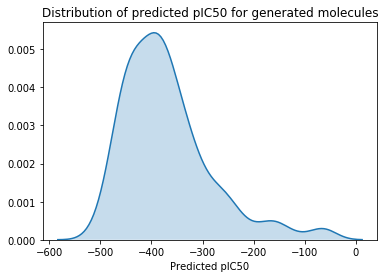

In [48]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=10000)

In [50]:
smiles_unbiased

array(['BCc1c(F)cc1C(=O)CC', 'C', 'C#CCCCCC', 'C1CCCCC1', 'C1CCCCCC1',
       'C1cO1', 'C=C(C)C', 'C=C(C)N', 'C=C(CC(C)(C)O)NCNCC1CCC1CCC',
       'C=C(O)CCCCC', 'C=C1CC(C)nC1C1CCCCN(C(=O)O)CC1', 'C=C1CN1CCCC',
       'C=CS(=O)C(C)(N)NC(C)(C)OC', 'C=Cc1ccc(Cl)cc1O', 'C=NCC',
       'C=Nc1ccc(C(=O)OC)cc1', 'C=O', 'CC',
       'CC(=N)N(CC(=O)O)CC(=O)NC(C)C', 'CC(=N)c1ccc(C)cc1',
       'CC(=O)C1CC(=O)C1=O', 'CC(=O)C1CC(C)C1', 'CC(=O)C1CCN(C)CC1=O',
       'CC(=O)CCO', 'CC(=O)O', 'CC(=O)Oc1ccc(C)nn1', 'CC(=O)c1ccccc1CN',
       'CC(C)=O', 'CC(C)C(=O)C(O)C(=O)O', 'CC(C)C(=O)F', 'CC(C)C1CC1',
       'CC(C)CC1CCC(C)C2CC2CC1C#N', 'CC(C)OCOc1cc(Cl)c1',
       'CC(C)S(=O)c1ccc(N)cn1', 'CC(N)=O', 'CC(N)C1C(=O)CC1c1ccccc1',
       'CC(N)C=O', 'CC(N)CCOc1cc(O)n1', 'CC(NC(=O)C(=O)O)C(C)C(=O)N1CCC1',
       'CC(O)(CO)c1ccc(F)cc1',
       'CC(O)CCCCNC1CC(NC(=O)C2CCCCC(N)C(CN3CC3C)O2)O1', 'CC(O)N(C)N',
       'CC(OCC(O)COc1ccccc1)C(N)=O', 'CC(c1cccc(Cl)c1)C1CC1',
       'CC1(O)CCCC1', 'CC1=C(O)C1', 'C

In [51]:
generated_mols_max = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_unbiased]
sanitized_gen_mols_max = [generated_mols_max[i] 
                          for i in np.where(np.array(generated_mols_max) != None)[0]]

In [52]:
n_to_draw = 10
ind = np.random.randint(0, len(sanitized_gen_mols_max), n_to_draw)
mols_to_draw_max = [sanitized_gen_mols_max[i] for i in ind]
legends = ['H = ' + str(prediction_unbiased[i]) for i in ind]

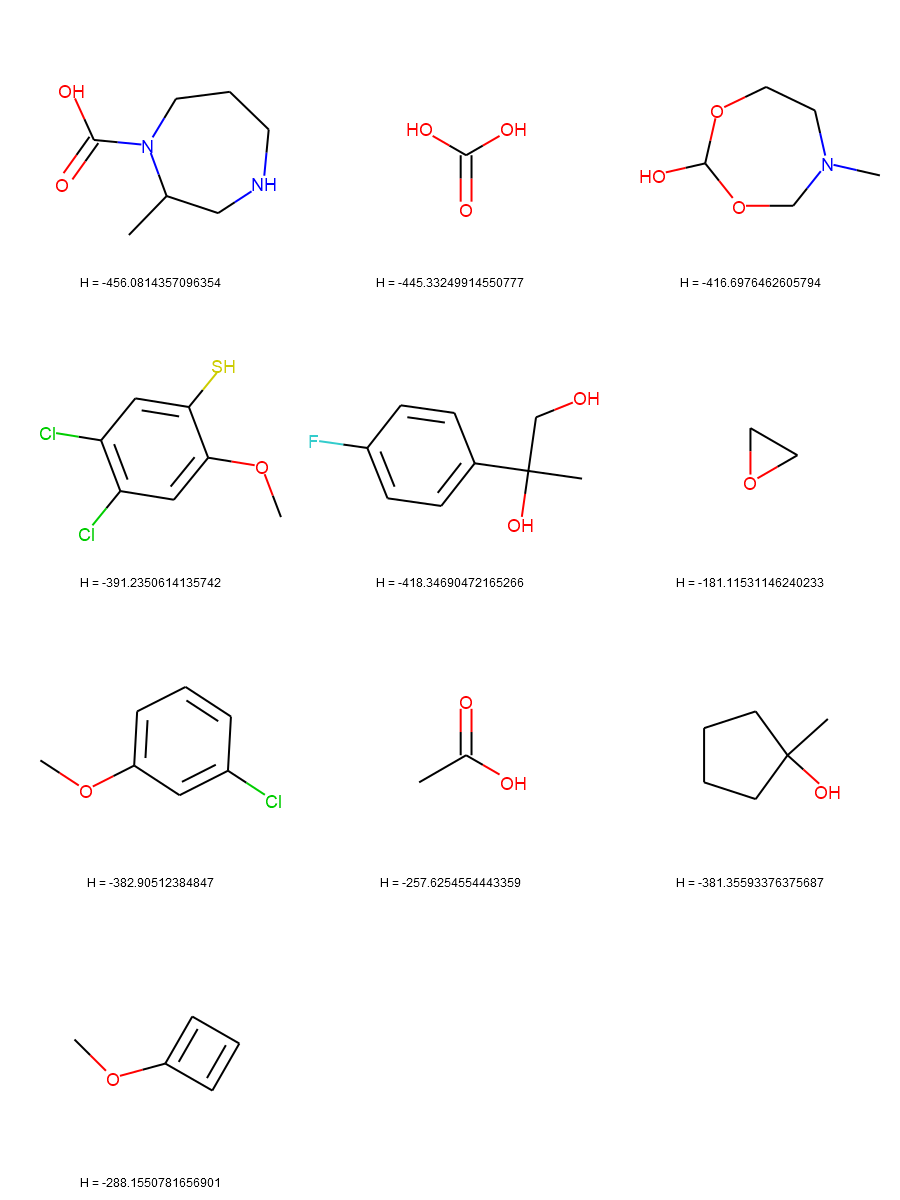

In [55]:
Draw.MolsToGridImage(mols_to_draw_max, 
                     subImgSize=(300,300), legends=legends)